> # House Price Prediction – Regression Modeling (ML2)
>
>Performed by: Zahra Eshtiaghi 476679
>
>Under Supervision of Professor Paweł Sakowski 
>
> **Introduction**
>
> In this notebook, We build and compare strong tree-based regression models (XGBoost, LightGBM, and CatBoost) to predict house/apartment sale prices using the Ames Housing dataset. The target variable is transformed using **log1p(SalePrice)** to match Kaggle-style evaluation (RMSLE / log-RMSE).
>
> The main goal of the project is not only achieving a low error, but also reducing overfitting and selecting a model that generalizes well. To do this, I evaluate models using **5-fold cross-validation** and analyze overfitting by comparing training vs validation log-RMSE across folds (including visual plots).
>
> **Notebook structure:**
>
> 1. Load prepared dataset and preprocessing outputs
> 2. Feature selection (Lasso-based) to reduce noise and improve generalization
> 3. Cross-validation evaluation of XGBoost, LightGBM, and CatBoost with early stopping
> 4. Overfitting visualization (train vs validation curves across folds)
> 5. Final model choice and justification
> 6. Train final model on full training data and generate test predictions + submission file



In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import xgboost as xgb
from scipy.stats import randint, uniform
import lightgbm as lgb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor


In [3]:


with open("/Users/majid/Documents/3-third semester/ML2/project/house-prices-advanced-regression-techniques/pickle/prepared_data.pkl", "rb") as f:
    prep = pickle.load(f)

X_train = prep["X_train"]
X_val   = prep["X_val"]
X_test  = prep["X_test"]

y_train_log = prep["y_train_log"]
y_val_log   = prep["y_val_log"]

print(X_train.shape, X_val.shape, X_test.shape)


(1168, 208) (292, 208) (1459, 208)


In [4]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


**CV + feature selection + tuning pipeline**
- ✅ Pipeline = (Lasso feature selection) → (XGBoost)
- This is strong for small datasets with many one-hot features.

In [5]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline(steps=[
    # Feature selection inside CV (prevents leakage)
    ("fs", SelectFromModel(
        estimator=LassoCV(
            cv=5,
            random_state=42,
            max_iter=8000,
            n_alphas=60
        ),
        # keep a controlled number of features to reduce overfitting
        max_features=80
    )),
    
    ("model", xgb.XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        eval_metric="rmse"
    ))
])


**RandomizedSearchCV**

This search space is regularization-aware (so it won’t “choose” reg_lambda=0 and overfit).

In [6]:
param_dist = {
    "fs__max_features": randint(40, 120),  # feature count range
    
    "model__n_estimators": randint(300, 1400),
    "model__learning_rate": uniform(0.01, 0.09),   # 0.01–0.10
    "model__max_depth": randint(2, 5),             # shallow trees
    "model__min_child_weight": randint(1, 10),
    
    "model__subsample": uniform(0.55, 0.40),       # 0.55–0.95
    "model__colsample_bytree": uniform(0.45, 0.50),# 0.45–0.95
    
    "model__reg_alpha": uniform(0.0, 0.3),         # L1
    "model__reg_lambda": uniform(0.8, 3.0),        # L2 (no zero)
    "model__gamma": uniform(0.0, 0.3)              # split penalty
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=40,   # 30–60 is usually enough 
    scoring="neg_root_mean_squared_error",  # log-RMSE
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train_log)

print("Best CV log-RMSE:", -search.best_score_)
print("Best params:", search.best_params_)
best_model = search.best_estimator_


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=91, model__colsample_bytree=0.925357153204958, model__gamma=0.21959818254342153, model__learning_rate=0.0638792635777333, model__max_depth=4, model__min_child_weight=3, model__n_estimators=630, model__reg_alpha=0.13777466758976015, model__reg_lambda=1.8011258334170657, model__subsample=0.6071467271687764; total time=   1.4s
[CV] END fs__max_features=91, model__colsample_bytree=0.925357153204958, model__gamma=0.21959818254342153, model__learning_rate=0.0638792635777333, model__max_depth=4, model__min_child_weight=3, model__n_estimators=630, model__reg_alpha=0.13777466758976015, model__reg_lambda=1.8011258334170657, model__subsample=0.6071467271687764; total time=   1.4s
[CV] END fs__max_features=42, model__colsample_bytree=0.46029224714790123, model__gamma=0.29097295564859826, model__learning_rate=0.08491983767203795, model__max_depth=3, model__min_child_weight=2, model__n_estimators=1255, model__reg_alpha=0.055021352956030146, model__reg_lambda=1.7127267288786

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=91, model__colsample_bytree=0.925357153204958, model__gamma=0.21959818254342153, model__learning_rate=0.0638792635777333, model__max_depth=4, model__min_child_weight=3, model__n_estimators=630, model__reg_alpha=0.13777466758976015, model__reg_lambda=1.8011258334170657, model__subsample=0.6071467271687764; total time=   1.6s
[CV] END fs__max_features=42, model__colsample_bytree=0.46029224714790123, model__gamma=0.29097295564859826, model__learning_rate=0.08491983767203795, model__max_depth=3, model__min_child_weight=2, model__n_estimators=1255, model__reg_alpha=0.055021352956030146, model__reg_lambda=1.7127267288786132, model__subsample=0.7599025726528952; total time=   1.6s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=42, model__colsample_bytree=0.46029224714790123, model__gamma=0.29097295564859826, model__learning_rate=0.08491983767203795, model__max_depth=3, model__min_child_weight=2, model__n_estimators=1255, model__reg_alpha=0.055021352956030146, model__reg_lambda=1.7127267288786132, model__subsample=0.7599025726528952; total time=   1.3s
[CV] END fs__max_features=42, model__colsample_bytree=0.46029224714790123, model__gamma=0.29097295564859826, model__learning_rate=0.08491983767203795, model__max_depth=3, model__min_child_weight=2, model__n_estimators=1255, model__reg_alpha=0.055021352956030146, model__reg_lambda=1.7127267288786132, model__subsample=0.7599025726528952; total time=   1.4s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=112, model__colsample_bytree=0.48252579649263977, model__gamma=0.28466566117599995, model__learning_rate=0.09690688297671034, model__max_depth=3, model__min_child_weight=9, model__n_estimators=864, model__reg_alpha=0.0692681476866447, model__reg_lambda=1.523076398078035, model__subsample=0.8233054075301833; total time=   1.2s
[CV] END fs__max_features=88, model__colsample_bytree=0.7123873301291945, model__gamma=0.11995829151457664, model__learning_rate=0.014199909689225389, model__max_depth=4, model__min_child_weight=3, model__n_estimators=1131, model__reg_alpha=0.14002886797439398, model__reg_lambda=3.379821220208962, model__subsample=0.822123015435112; total time=   1.7s
[CV] END fs__max_features=88, model__colsample_bytree=0.7123873301291945, model__gamma=0.11995829151457664, model__learning_rate=0.014199909689225389, model__max_depth=4, model__min_child_weight=3, model__n_estimators=1131, model__reg_alpha=0.14002886797439398, model__reg_lambda=3.3798212202

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=88, model__colsample_bytree=0.7123873301291945, model__gamma=0.11995829151457664, model__learning_rate=0.014199909689225389, model__max_depth=4, model__min_child_weight=3, model__n_estimators=1131, model__reg_alpha=0.14002886797439398, model__reg_lambda=3.379821220208962, model__subsample=0.822123015435112; total time=   1.9s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=112, model__colsample_bytree=0.48252579649263977, model__gamma=0.28466566117599995, model__learning_rate=0.09690688297671034, model__max_depth=3, model__min_child_weight=9, model__n_estimators=864, model__reg_alpha=0.0692681476866447, model__reg_lambda=1.523076398078035, model__subsample=0.8233054075301833; total time=   1.4s
[CV] END fs__max_features=112, model__colsample_bytree=0.48252579649263977, model__gamma=0.28466566117599995, model__learning_rate=0.09690688297671034, model__max_depth=3, model__min_child_weight=9, model__n_estimators=864, model__reg_alpha=0.0692681476866447, model__reg_lambda=1.523076398078035, model__subsample=0.8233054075301833; total time=   1.4s
[CV] END fs__max_features=112, model__colsample_bytree=0.48252579649263977, model__gamma=0.28466566117599995, model__learning_rate=0.09690688297671034, model__max_depth=3, model__min_child_weight=9, model__n_estimators=864, model__reg_alpha=0.0692681476866447, model__reg_lambda=1.52307639807

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=83, model__colsample_bytree=0.697588455055635, model__gamma=0.010316556334565519, model__learning_rate=0.09183883618709038, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1325, model__reg_alpha=0.12754676234737342, model__reg_lambda=1.4238249886045664, model__subsample=0.7770801311279967; total time=   1.6s
[CV] END fs__max_features=83, model__colsample_bytree=0.697588455055635, model__gamma=0.010316556334565519, model__learning_rate=0.09183883618709038, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1325, model__reg_alpha=0.12754676234737342, model__reg_lambda=1.4238249886045664, model__subsample=0.7770801311279967; total time=   1.6s
[CV] END fs__max_features=83, model__colsample_bytree=0.697588455055635, model__gamma=0.010316556334565519, model__learning_rate=0.09183883618709038, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1325, model__reg_alpha=0.12754676234737342, model__reg_lambda=1.423824988

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=83, model__colsample_bytree=0.697588455055635, model__gamma=0.010316556334565519, model__learning_rate=0.09183883618709038, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1325, model__reg_alpha=0.12754676234737342, model__reg_lambda=1.4238249886045664, model__subsample=0.7770801311279967; total time=   1.4s
[CV] END fs__max_features=102, model__colsample_bytree=0.8711423872974993, model__gamma=0.1349262400109297, model__learning_rate=0.0455635212401633, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1316, model__reg_alpha=0.28835160730480475, model__reg_lambda=3.333601546034454, model__subsample=0.8489280440549525; total time=   1.4s
[CV] END fs__max_features=102, model__colsample_bytree=0.8711423872974993, model__gamma=0.1349262400109297, model__learning_rate=0.0455635212401633, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1316, model__reg_alpha=0.28835160730480475, model__reg_lambda=3.333601546034

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=92, model__colsample_bytree=0.7433755828319242, model__gamma=0.28957659217924137, model__learning_rate=0.06463308229180162, model__max_depth=2, model__min_child_weight=9, model__n_estimators=314, model__reg_alpha=0.04958008171890075, model__reg_lambda=0.8469092202235818, model__subsample=0.7193605922825479; total time=   0.9s
[CV] END fs__max_features=102, model__colsample_bytree=0.8711423872974993, model__gamma=0.1349262400109297, model__learning_rate=0.0455635212401633, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1316, model__reg_alpha=0.28835160730480475, model__reg_lambda=3.333601546034454, model__subsample=0.8489280440549525; total time=   1.6s
[CV] END fs__max_features=92, model__colsample_bytree=0.7433755828319242, model__gamma=0.28957659217924137, model__learning_rate=0.06463308229180162, model__max_depth=2, model__min_child_weight=9, model__n_estimators=314, model__reg_alpha=0.04958008171890075, model__reg_lambda=0.8469092202235

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=102, model__colsample_bytree=0.8711423872974993, model__gamma=0.1349262400109297, model__learning_rate=0.0455635212401633, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1316, model__reg_alpha=0.28835160730480475, model__reg_lambda=3.333601546034454, model__subsample=0.8489280440549525; total time=   1.3s
[CV] END fs__max_features=102, model__colsample_bytree=0.8711423872974993, model__gamma=0.1349262400109297, model__learning_rate=0.0455635212401633, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1316, model__reg_alpha=0.28835160730480475, model__reg_lambda=3.333601546034454, model__subsample=0.8489280440549525; total time=   1.4s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=92, model__colsample_bytree=0.7433755828319242, model__gamma=0.28957659217924137, model__learning_rate=0.06463308229180162, model__max_depth=2, model__min_child_weight=9, model__n_estimators=314, model__reg_alpha=0.04958008171890075, model__reg_lambda=0.8469092202235818, model__subsample=0.7193605922825479; total time=   1.1s
[CV] END fs__max_features=92, model__colsample_bytree=0.7433755828319242, model__gamma=0.28957659217924137, model__learning_rate=0.06463308229180162, model__max_depth=2, model__min_child_weight=9, model__n_estimators=314, model__reg_alpha=0.04958008171890075, model__reg_lambda=0.8469092202235818, model__subsample=0.7193605922825479; total time=   1.1s
[CV] END fs__max_features=92, model__colsample_bytree=0.7433755828319242, model__gamma=0.28957659217924137, model__learning_rate=0.06463308229180162, model__max_depth=2, model__min_child_weight=9, model__n_estimators=314, model__reg_alpha=0.04958008171890075, model__reg_lambda=0.846909220223

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=40, model__colsample_bytree=0.5493578407670863, model__gamma=0.0016566351370807197, model__learning_rate=0.08339152856093507, model__max_depth=2, model__min_child_weight=8, model__n_estimators=718, model__reg_alpha=0.2313811040057837, model__reg_lambda=1.0221339552022712, model__subsample=0.6933862914177091; total time=   1.3s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=40, model__colsample_bytree=0.5493578407670863, model__gamma=0.0016566351370807197, model__learning_rate=0.08339152856093507, model__max_depth=2, model__min_child_weight=8, model__n_estimators=718, model__reg_alpha=0.2313811040057837, model__reg_lambda=1.0221339552022712, model__subsample=0.6933862914177091; total time=   1.3s
[CV] END fs__max_features=40, model__colsample_bytree=0.5493578407670863, model__gamma=0.0016566351370807197, model__learning_rate=0.08339152856093507, model__max_depth=2, model__min_child_weight=8, model__n_estimators=718, model__reg_alpha=0.2313811040057837, model__reg_lambda=1.0221339552022712, model__subsample=0.6933862914177091; total time=   1.4s
[CV] END fs__max_features=40, model__colsample_bytree=0.5493578407670863, model__gamma=0.0016566351370807197, model__learning_rate=0.08339152856093507, model__max_depth=2, model__min_child_weight=8, model__n_estimators=718, model__reg_alpha=0.2313811040057837, model__reg_lambda=1.022133955

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=40, model__colsample_bytree=0.5493578407670863, model__gamma=0.0016566351370807197, model__learning_rate=0.08339152856093507, model__max_depth=2, model__min_child_weight=8, model__n_estimators=718, model__reg_alpha=0.2313811040057837, model__reg_lambda=1.0221339552022712, model__subsample=0.6933862914177091; total time=   1.4s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=80, model__colsample_bytree=0.9074798377718905, model__gamma=0.2550115733369398, model__learning_rate=0.050450560672438305, model__max_depth=2, model__min_child_weight=7, model__n_estimators=706, model__reg_alpha=0.20065237579908218, model__reg_lambda=2.7977670698524904, model__subsample=0.7865191150830909; total time=   1.3s
[CV] END fs__max_features=80, model__colsample_bytree=0.9074798377718905, model__gamma=0.2550115733369398, model__learning_rate=0.050450560672438305, model__max_depth=2, model__min_child_weight=7, model__n_estimators=706, model__reg_alpha=0.20065237579908218, model__reg_lambda=2.7977670698524904, model__subsample=0.7865191150830909; total time=   1.3s
[CV] END fs__max_features=80, model__colsample_bytree=0.9074798377718905, model__gamma=0.2550115733369398, model__learning_rate=0.050450560672438305, model__max_depth=2, model__min_child_weight=7, model__n_estimators=706, model__reg_alpha=0.20065237579908218, model__reg_lambda=2.797767069852

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=80, model__colsample_bytree=0.9074798377718905, model__gamma=0.2550115733369398, model__learning_rate=0.050450560672438305, model__max_depth=2, model__min_child_weight=7, model__n_estimators=706, model__reg_alpha=0.20065237579908218, model__reg_lambda=2.7977670698524904, model__subsample=0.7865191150830909; total time=   1.3s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=80, model__colsample_bytree=0.9074798377718905, model__gamma=0.2550115733369398, model__learning_rate=0.050450560672438305, model__max_depth=2, model__min_child_weight=7, model__n_estimators=706, model__reg_alpha=0.20065237579908218, model__reg_lambda=2.7977670698524904, model__subsample=0.7865191150830909; total time=   1.1s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=74, model__colsample_bytree=0.6861074625809747, model__gamma=0.035878273781490506, model__learning_rate=0.07419203085006955, model__max_depth=2, model__min_child_weight=5, model__n_estimators=802, model__reg_alpha=0.2312901539863683, model__reg_lambda=2.2813867890931725, model__subsample=0.7590931317527977; total time=   1.4s
[CV] END fs__max_features=74, model__colsample_bytree=0.6861074625809747, model__gamma=0.035878273781490506, model__learning_rate=0.07419203085006955, model__max_depth=2, model__min_child_weight=5, model__n_estimators=802, model__reg_alpha=0.2312901539863683, model__reg_lambda=2.2813867890931725, model__subsample=0.7590931317527977; total time=   1.4s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=74, model__colsample_bytree=0.6861074625809747, model__gamma=0.035878273781490506, model__learning_rate=0.07419203085006955, model__max_depth=2, model__min_child_weight=5, model__n_estimators=802, model__reg_alpha=0.2312901539863683, model__reg_lambda=2.2813867890931725, model__subsample=0.7590931317527977; total time=   1.4s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=74, model__colsample_bytree=0.6861074625809747, model__gamma=0.035878273781490506, model__learning_rate=0.07419203085006955, model__max_depth=2, model__min_child_weight=5, model__n_estimators=802, model__reg_alpha=0.2312901539863683, model__reg_lambda=2.2813867890931725, model__subsample=0.7590931317527977; total time=   1.2s
[CV] END fs__max_features=54, model__colsample_bytree=0.5054454104059156, model__gamma=0.13180095055973104, model__learning_rate=0.028154728210185657, model__max_depth=4, model__min_child_weight=1, model__n_estimators=863, model__reg_alpha=0.1689826715929151, model__reg_lambda=2.886548259278382, model__subsample=0.6057325817623503; total time=   1.3s
[CV] END fs__max_features=74, model__colsample_bytree=0.6861074625809747, model__gamma=0.035878273781490506, model__learning_rate=0.07419203085006955, model__max_depth=2, model__min_child_weight=5, model__n_estimators=802, model__reg_alpha=0.2312901539863683, model__reg_lambda=2.2813867890931

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=54, model__colsample_bytree=0.5054454104059156, model__gamma=0.13180095055973104, model__learning_rate=0.028154728210185657, model__max_depth=4, model__min_child_weight=1, model__n_estimators=863, model__reg_alpha=0.1689826715929151, model__reg_lambda=2.886548259278382, model__subsample=0.6057325817623503; total time=   1.3s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=54, model__colsample_bytree=0.5054454104059156, model__gamma=0.13180095055973104, model__learning_rate=0.028154728210185657, model__max_depth=4, model__min_child_weight=1, model__n_estimators=863, model__reg_alpha=0.1689826715929151, model__reg_lambda=2.886548259278382, model__subsample=0.6057325817623503; total time=   1.5s
[CV] END fs__max_features=54, model__colsample_bytree=0.5054454104059156, model__gamma=0.13180095055973104, model__learning_rate=0.028154728210185657, model__max_depth=4, model__min_child_weight=1, model__n_estimators=863, model__reg_alpha=0.1689826715929151, model__reg_lambda=2.886548259278382, model__subsample=0.6057325817623503; total time=   1.2s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=54, model__colsample_bytree=0.5054454104059156, model__gamma=0.13180095055973104, model__learning_rate=0.028154728210185657, model__max_depth=4, model__min_child_weight=1, model__n_estimators=863, model__reg_alpha=0.1689826715929151, model__reg_lambda=2.886548259278382, model__subsample=0.6057325817623503; total time=   1.4s
[CV] END fs__max_features=54, model__colsample_bytree=0.8277755692715243, model__gamma=0.06863944964748674, model__learning_rate=0.016928191884591368, model__max_depth=4, model__min_child_weight=3, model__n_estimators=877, model__reg_alpha=0.18730621444013798, model__reg_lambda=1.686901057513142, model__subsample=0.5921977039321082; total time=   1.5s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=54, model__colsample_bytree=0.8277755692715243, model__gamma=0.06863944964748674, model__learning_rate=0.016928191884591368, model__max_depth=4, model__min_child_weight=3, model__n_estimators=877, model__reg_alpha=0.18730621444013798, model__reg_lambda=1.686901057513142, model__subsample=0.5921977039321082; total time=   1.5s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=67, model__colsample_bytree=0.8518360384495572, model__gamma=0.05597101766581075, model__learning_rate=0.09033030986409799, model__max_depth=4, model__min_child_weight=7, model__n_estimators=489, model__reg_alpha=0.033015577358303023, model__reg_lambda=1.483805487625825, model__subsample=0.7208431154505026; total time=   1.3s
[CV] END fs__max_features=54, model__colsample_bytree=0.8277755692715243, model__gamma=0.06863944964748674, model__learning_rate=0.016928191884591368, model__max_depth=4, model__min_child_weight=3, model__n_estimators=877, model__reg_alpha=0.18730621444013798, model__reg_lambda=1.686901057513142, model__subsample=0.5921977039321082; total time=   1.8s
[CV] END fs__max_features=54, model__colsample_bytree=0.8277755692715243, model__gamma=0.06863944964748674, model__learning_rate=0.016928191884591368, model__max_depth=4, model__min_child_weight=3, model__n_estimators=877, model__reg_alpha=0.18730621444013798, model__reg_lambda=1.68690105751

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=67, model__colsample_bytree=0.8518360384495572, model__gamma=0.05597101766581075, model__learning_rate=0.09033030986409799, model__max_depth=4, model__min_child_weight=7, model__n_estimators=489, model__reg_alpha=0.033015577358303023, model__reg_lambda=1.483805487625825, model__subsample=0.7208431154505026; total time=   1.3s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=67, model__colsample_bytree=0.8518360384495572, model__gamma=0.05597101766581075, model__learning_rate=0.09033030986409799, model__max_depth=4, model__min_child_weight=7, model__n_estimators=489, model__reg_alpha=0.033015577358303023, model__reg_lambda=1.483805487625825, model__subsample=0.7208431154505026; total time=   1.6s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=67, model__colsample_bytree=0.8518360384495572, model__gamma=0.05597101766581075, model__learning_rate=0.09033030986409799, model__max_depth=4, model__min_child_weight=7, model__n_estimators=489, model__reg_alpha=0.033015577358303023, model__reg_lambda=1.483805487625825, model__subsample=0.7208431154505026; total time=   1.6s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=67, model__colsample_bytree=0.8518360384495572, model__gamma=0.05597101766581075, model__learning_rate=0.09033030986409799, model__max_depth=4, model__min_child_weight=7, model__n_estimators=489, model__reg_alpha=0.033015577358303023, model__reg_lambda=1.483805487625825, model__subsample=0.7208431154505026; total time=   1.5s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=116, model__colsample_bytree=0.8803652916281717, model__gamma=0.002085639159357211, model__learning_rate=0.05596725723198091, model__max_depth=2, model__min_child_weight=5, model__n_estimators=983, model__reg_alpha=0.07323765667433225, model__reg_lambda=1.3048731265187916, model__subsample=0.6375056878292281; total time=   1.8s
[CV] END fs__max_features=116, model__colsample_bytree=0.8803652916281717, model__gamma=0.002085639159357211, model__learning_rate=0.05596725723198091, model__max_depth=2, model__min_child_weight=5, model__n_estimators=983, model__reg_alpha=0.07323765667433225, model__reg_lambda=1.3048731265187916, model__subsample=0.6375056878292281; total time=   1.8s
[CV] END fs__max_features=116, model__colsample_bytree=0.8803652916281717, model__gamma=0.002085639159357211, model__learning_rate=0.05596725723198091, model__max_depth=2, model__min_child_weight=5, model__n_estimators=983, model__reg_alpha=0.07323765667433225, model__reg_lambda=1.304873

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=116, model__colsample_bytree=0.8803652916281717, model__gamma=0.002085639159357211, model__learning_rate=0.05596725723198091, model__max_depth=2, model__min_child_weight=5, model__n_estimators=983, model__reg_alpha=0.07323765667433225, model__reg_lambda=1.3048731265187916, model__subsample=0.6375056878292281; total time=   1.8s
[CV] END fs__max_features=116, model__colsample_bytree=0.8803652916281717, model__gamma=0.002085639159357211, model__learning_rate=0.05596725723198091, model__max_depth=2, model__min_child_weight=5, model__n_estimators=983, model__reg_alpha=0.07323765667433225, model__reg_lambda=1.3048731265187916, model__subsample=0.6375056878292281; total time=   1.8s
[CV] END fs__max_features=91, model__colsample_bytree=0.631814801189647, model__gamma=0.29153462481628817, model__learning_rate=0.09662025654479, model__max_depth=3, model__min_child_weight=7, model__n_estimators=1251, model__reg_alpha=0.011066084206359838, model__reg_lambda=2.6286930019

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=91, model__colsample_bytree=0.631814801189647, model__gamma=0.29153462481628817, model__learning_rate=0.09662025654479, model__max_depth=3, model__min_child_weight=7, model__n_estimators=1251, model__reg_alpha=0.011066084206359838, model__reg_lambda=2.6286930019396904, model__subsample=0.7510716092915446; total time=   1.3s
[CV] END fs__max_features=91, model__colsample_bytree=0.631814801189647, model__gamma=0.29153462481628817, model__learning_rate=0.09662025654479, model__max_depth=3, model__min_child_weight=7, model__n_estimators=1251, model__reg_alpha=0.011066084206359838, model__reg_lambda=2.6286930019396904, model__subsample=0.7510716092915446; total time=   1.6s
[CV] END fs__max_features=91, model__colsample_bytree=0.631814801189647, model__gamma=0.29153462481628817, model__learning_rate=0.09662025654479, model__max_depth=3, model__min_child_weight=7, model__n_estimators=1251, model__reg_alpha=0.011066084206359838, model__reg_lambda=2.6286930019396904, 

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=91, model__colsample_bytree=0.631814801189647, model__gamma=0.29153462481628817, model__learning_rate=0.09662025654479, model__max_depth=3, model__min_child_weight=7, model__n_estimators=1251, model__reg_alpha=0.011066084206359838, model__reg_lambda=2.6286930019396904, model__subsample=0.7510716092915446; total time=   1.3s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=93, model__colsample_bytree=0.4665253664502742, model__gamma=0.1035213744080049, model__learning_rate=0.06709162102312273, model__max_depth=3, model__min_child_weight=2, model__n_estimators=1376, model__reg_alpha=0.1468358280832689, model__reg_lambda=3.756951362331802, model__subsample=0.6468221086046002; total time=   1.5s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=93, model__colsample_bytree=0.4665253664502742, model__gamma=0.1035213744080049, model__learning_rate=0.06709162102312273, model__max_depth=3, model__min_child_weight=2, model__n_estimators=1376, model__reg_alpha=0.1468358280832689, model__reg_lambda=3.756951362331802, model__subsample=0.6468221086046002; total time=   1.3s
[CV] END fs__max_features=93, model__colsample_bytree=0.4665253664502742, model__gamma=0.1035213744080049, model__learning_rate=0.06709162102312273, model__max_depth=3, model__min_child_weight=2, model__n_estimators=1376, model__reg_alpha=0.1468358280832689, model__reg_lambda=3.756951362331802, model__subsample=0.6468221086046002; total time=   1.4s
[CV] END fs__max_features=93, model__colsample_bytree=0.4665253664502742, model__gamma=0.1035213744080049, model__learning_rate=0.06709162102312273, model__max_depth=3, model__min_child_weight=2, model__n_estimators=1376, model__reg_alpha=0.1468358280832689, model__reg_lambda=3.756951362331802, 

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=93, model__colsample_bytree=0.4665253664502742, model__gamma=0.1035213744080049, model__learning_rate=0.06709162102312273, model__max_depth=3, model__min_child_weight=2, model__n_estimators=1376, model__reg_alpha=0.1468358280832689, model__reg_lambda=3.756951362331802, model__subsample=0.6468221086046002; total time=   1.7s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=107, model__colsample_bytree=0.49042666316635763, model__gamma=0.11089633681842133, model__learning_rate=0.03179439444496833, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1183, model__reg_alpha=0.2950269422684529, model__reg_lambda=1.9964733273336592, model__subsample=0.8765727492877536; total time=   1.4s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=107, model__colsample_bytree=0.49042666316635763, model__gamma=0.11089633681842133, model__learning_rate=0.03179439444496833, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1183, model__reg_alpha=0.2950269422684529, model__reg_lambda=1.9964733273336592, model__subsample=0.8765727492877536; total time=   1.4s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=107, model__colsample_bytree=0.49042666316635763, model__gamma=0.11089633681842133, model__learning_rate=0.03179439444496833, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1183, model__reg_alpha=0.2950269422684529, model__reg_lambda=1.9964733273336592, model__subsample=0.8765727492877536; total time=   1.6s
[CV] END fs__max_features=107, model__colsample_bytree=0.49042666316635763, model__gamma=0.11089633681842133, model__learning_rate=0.03179439444496833, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1183, model__reg_alpha=0.2950269422684529, model__reg_lambda=1.9964733273336592, model__subsample=0.8765727492877536; total time=   1.5s
[CV] END fs__max_features=55, model__colsample_bytree=0.867651247794619, model__gamma=0.09623401949152074, model__learning_rate=0.02678666593598688, model__max_depth=2, model__min_child_weight=3, model__n_estimators=959, model__reg_alpha=0.09778767156056542, model__reg_lambda=1.460723142

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=107, model__colsample_bytree=0.49042666316635763, model__gamma=0.11089633681842133, model__learning_rate=0.03179439444496833, model__max_depth=3, model__min_child_weight=8, model__n_estimators=1183, model__reg_alpha=0.2950269422684529, model__reg_lambda=1.9964733273336592, model__subsample=0.8765727492877536; total time=   1.3s
[CV] END fs__max_features=55, model__colsample_bytree=0.867651247794619, model__gamma=0.09623401949152074, model__learning_rate=0.02678666593598688, model__max_depth=2, model__min_child_weight=3, model__n_estimators=959, model__reg_alpha=0.09778767156056542, model__reg_lambda=1.460723142696645, model__subsample=0.8344598129752072; total time=   1.3s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=55, model__colsample_bytree=0.867651247794619, model__gamma=0.09623401949152074, model__learning_rate=0.02678666593598688, model__max_depth=2, model__min_child_weight=3, model__n_estimators=959, model__reg_alpha=0.09778767156056542, model__reg_lambda=1.460723142696645, model__subsample=0.8344598129752072; total time=   1.5s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=55, model__colsample_bytree=0.867651247794619, model__gamma=0.09623401949152074, model__learning_rate=0.02678666593598688, model__max_depth=2, model__min_child_weight=3, model__n_estimators=959, model__reg_alpha=0.09778767156056542, model__reg_lambda=1.460723142696645, model__subsample=0.8344598129752072; total time=   1.7s
[CV] END fs__max_features=55, model__colsample_bytree=0.867651247794619, model__gamma=0.09623401949152074, model__learning_rate=0.02678666593598688, model__max_depth=2, model__min_child_weight=3, model__n_estimators=959, model__reg_alpha=0.09778767156056542, model__reg_lambda=1.460723142696645, model__subsample=0.8344598129752072; total time=   1.4s
[CV] END fs__max_features=58, model__colsample_bytree=0.6243329936458647, model__gamma=0.028852965327426226, model__learning_rate=0.09464709380406434, model__max_depth=4, model__min_child_weight=2, model__n_estimators=1171, model__reg_alpha=0.04125628324379797, model__reg_lambda=1.82319905315077

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=58, model__colsample_bytree=0.6243329936458647, model__gamma=0.028852965327426226, model__learning_rate=0.09464709380406434, model__max_depth=4, model__min_child_weight=2, model__n_estimators=1171, model__reg_alpha=0.04125628324379797, model__reg_lambda=1.8231990531507756, model__subsample=0.5953894084962357; total time=   1.6s
[CV] END fs__max_features=58, model__colsample_bytree=0.6243329936458647, model__gamma=0.028852965327426226, model__learning_rate=0.09464709380406434, model__max_depth=4, model__min_child_weight=2, model__n_estimators=1171, model__reg_alpha=0.04125628324379797, model__reg_lambda=1.8231990531507756, model__subsample=0.5953894084962357; total time=   1.4s
[CV] END fs__max_features=58, model__colsample_bytree=0.6243329936458647, model__gamma=0.028852965327426226, model__learning_rate=0.09464709380406434, model__max_depth=4, model__min_child_weight=2, model__n_estimators=1171, model__reg_alpha=0.04125628324379797, model__reg_lambda=1.823199

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=62, model__colsample_bytree=0.7207239869137829, model__gamma=0.20873531980352464, model__learning_rate=0.03056950196175697, model__max_depth=3, model__min_child_weight=9, model__n_estimators=1180, model__reg_alpha=0.0725556872701355, model__reg_lambda=1.0793083034176978, model__subsample=0.9088863031813308; total time=   1.3s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=62, model__colsample_bytree=0.7207239869137829, model__gamma=0.20873531980352464, model__learning_rate=0.03056950196175697, model__max_depth=3, model__min_child_weight=9, model__n_estimators=1180, model__reg_alpha=0.0725556872701355, model__reg_lambda=1.0793083034176978, model__subsample=0.9088863031813308; total time=   1.2s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=62, model__colsample_bytree=0.7207239869137829, model__gamma=0.20873531980352464, model__learning_rate=0.03056950196175697, model__max_depth=3, model__min_child_weight=9, model__n_estimators=1180, model__reg_alpha=0.0725556872701355, model__reg_lambda=1.0793083034176978, model__subsample=0.9088863031813308; total time=   1.4s
[CV] END fs__max_features=62, model__colsample_bytree=0.7207239869137829, model__gamma=0.20873531980352464, model__learning_rate=0.03056950196175697, model__max_depth=3, model__min_child_weight=9, model__n_estimators=1180, model__reg_alpha=0.0725556872701355, model__reg_lambda=1.0793083034176978, model__subsample=0.9088863031813308; total time=   1.4s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=62, model__colsample_bytree=0.7207239869137829, model__gamma=0.20873531980352464, model__learning_rate=0.03056950196175697, model__max_depth=3, model__min_child_weight=9, model__n_estimators=1180, model__reg_alpha=0.0725556872701355, model__reg_lambda=1.0793083034176978, model__subsample=0.9088863031813308; total time=   1.2s
[CV] END fs__max_features=76, model__colsample_bytree=0.8913181715946699, model__gamma=0.056612132502413814, model__learning_rate=0.035098421733296366, model__max_depth=4, model__min_child_weight=3, model__n_estimators=703, model__reg_alpha=0.26612592727953516, model__reg_lambda=3.1396266375728716, model__subsample=0.8068126584617152; total time=   1.1s
[CV] END fs__max_features=76, model__colsample_bytree=0.8913181715946699, model__gamma=0.056612132502413814, model__learning_rate=0.035098421733296366, model__max_depth=4, model__min_child_weight=3, model__n_estimators=703, model__reg_alpha=0.26612592727953516, model__reg_lambda=3.13962663

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=76, model__colsample_bytree=0.8913181715946699, model__gamma=0.056612132502413814, model__learning_rate=0.035098421733296366, model__max_depth=4, model__min_child_weight=3, model__n_estimators=703, model__reg_alpha=0.26612592727953516, model__reg_lambda=3.1396266375728716, model__subsample=0.8068126584617152; total time=   1.3s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=114, model__colsample_bytree=0.9178174971104738, model__gamma=0.23560219533418306, model__learning_rate=0.07020894292428058, model__max_depth=3, model__min_child_weight=3, model__n_estimators=809, model__reg_alpha=0.2820400327373335, model__reg_lambda=3.720991510265952, model__subsample=0.6635683898949863; total time=   1.3s
[CV] END fs__max_features=114, model__colsample_bytree=0.9178174971104738, model__gamma=0.23560219533418306, model__learning_rate=0.07020894292428058, model__max_depth=3, model__min_child_weight=3, model__n_estimators=809, model__reg_alpha=0.2820400327373335, model__reg_lambda=3.720991510265952, model__subsample=0.6635683898949863; total time=   1.3s
[CV] END fs__max_features=114, model__colsample_bytree=0.9178174971104738, model__gamma=0.23560219533418306, model__learning_rate=0.07020894292428058, model__max_depth=3, model__min_child_weight=3, model__n_estimators=809, model__reg_alpha=0.2820400327373335, model__reg_lambda=3.72099151026595

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=105, model__colsample_bytree=0.7959475988463467, model__gamma=0.19558837785078015, model__learning_rate=0.030184237851450378, model__max_depth=2, model__min_child_weight=4, model__n_estimators=1100, model__reg_alpha=0.14816811455503037, model__reg_lambda=1.3364681276639865, model__subsample=0.696587513833144; total time=   1.3s
[CV] END fs__max_features=105, model__colsample_bytree=0.7959475988463467, model__gamma=0.19558837785078015, model__learning_rate=0.030184237851450378, model__max_depth=2, model__min_child_weight=4, model__n_estimators=1100, model__reg_alpha=0.14816811455503037, model__reg_lambda=1.3364681276639865, model__subsample=0.696587513833144; total time=   1.4s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=105, model__colsample_bytree=0.7959475988463467, model__gamma=0.19558837785078015, model__learning_rate=0.030184237851450378, model__max_depth=2, model__min_child_weight=4, model__n_estimators=1100, model__reg_alpha=0.14816811455503037, model__reg_lambda=1.3364681276639865, model__subsample=0.696587513833144; total time=   1.5s
[CV] END fs__max_features=105, model__colsample_bytree=0.7959475988463467, model__gamma=0.19558837785078015, model__learning_rate=0.030184237851450378, model__max_depth=2, model__min_child_weight=4, model__n_estimators=1100, model__reg_alpha=0.14816811455503037, model__reg_lambda=1.3364681276639865, model__subsample=0.696587513833144; total time=   1.3s
[CV] END fs__max_features=47, model__colsample_bytree=0.874611705247089, model__gamma=0.197283867690103, model__learning_rate=0.06114777430019244, model__max_depth=4, model__min_child_weight=3, model__n_estimators=769, model__reg_alpha=0.07956071030451763, model__reg_lambda=1.53196893013

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=47, model__colsample_bytree=0.874611705247089, model__gamma=0.197283867690103, model__learning_rate=0.06114777430019244, model__max_depth=4, model__min_child_weight=3, model__n_estimators=769, model__reg_alpha=0.07956071030451763, model__reg_lambda=1.5319689301372508, model__subsample=0.9392042219009783; total time=   1.3s
[CV] END fs__max_features=47, model__colsample_bytree=0.874611705247089, model__gamma=0.197283867690103, model__learning_rate=0.06114777430019244, model__max_depth=4, model__min_child_weight=3, model__n_estimators=769, model__reg_alpha=0.07956071030451763, model__reg_lambda=1.5319689301372508, model__subsample=0.9392042219009783; total time=   1.1s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=47, model__colsample_bytree=0.874611705247089, model__gamma=0.197283867690103, model__learning_rate=0.06114777430019244, model__max_depth=4, model__min_child_weight=3, model__n_estimators=769, model__reg_alpha=0.07956071030451763, model__reg_lambda=1.5319689301372508, model__subsample=0.9392042219009783; total time=   1.0s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=90, model__colsample_bytree=0.8960232775885566, model__gamma=0.18934158779917887, model__learning_rate=0.08153301731874835, model__max_depth=3, model__min_child_weight=1, model__n_estimators=583, model__reg_alpha=0.2006772178989299, model__reg_lambda=3.3925026952157094, model__subsample=0.6420741072966222; total time=   1.0s
[CV] END fs__max_features=90, model__colsample_bytree=0.8960232775885566, model__gamma=0.18934158779917887, model__learning_rate=0.08153301731874835, model__max_depth=3, model__min_child_weight=1, model__n_estimators=583, model__reg_alpha=0.2006772178989299, model__reg_lambda=3.3925026952157094, model__subsample=0.6420741072966222; total time=   1.2s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=90, model__colsample_bytree=0.8960232775885566, model__gamma=0.18934158779917887, model__learning_rate=0.08153301731874835, model__max_depth=3, model__min_child_weight=1, model__n_estimators=583, model__reg_alpha=0.2006772178989299, model__reg_lambda=3.3925026952157094, model__subsample=0.6420741072966222; total time=   1.1s
[CV] END fs__max_features=90, model__colsample_bytree=0.8960232775885566, model__gamma=0.18934158779917887, model__learning_rate=0.08153301731874835, model__max_depth=3, model__min_child_weight=1, model__n_estimators=583, model__reg_alpha=0.2006772178989299, model__reg_lambda=3.3925026952157094, model__subsample=0.6420741072966222; total time=   1.3s
[CV] END fs__max_features=90, model__colsample_bytree=0.8960232775885566, model__gamma=0.18934158779917887, model__learning_rate=0.08153301731874835, model__max_depth=3, model__min_child_weight=1, model__n_estimators=583, model__reg_alpha=0.2006772178989299, model__reg_lambda=3.392502695215709

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=87, model__colsample_bytree=0.5903861812204279, model__gamma=0.007294789929436152, model__learning_rate=0.0680925066316451, model__max_depth=2, model__min_child_weight=5, model__n_estimators=817, model__reg_alpha=0.11104761007663332, model__reg_lambda=0.8463698495866023, model__subsample=0.9213274250350902; total time=   1.3s
[CV] END fs__max_features=87, model__colsample_bytree=0.5903861812204279, model__gamma=0.007294789929436152, model__learning_rate=0.0680925066316451, model__max_depth=2, model__min_child_weight=5, model__n_estimators=817, model__reg_alpha=0.11104761007663332, model__reg_lambda=0.8463698495866023, model__subsample=0.9213274250350902; total time=   1.3s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=87, model__colsample_bytree=0.5903861812204279, model__gamma=0.007294789929436152, model__learning_rate=0.0680925066316451, model__max_depth=2, model__min_child_weight=5, model__n_estimators=817, model__reg_alpha=0.11104761007663332, model__reg_lambda=0.8463698495866023, model__subsample=0.9213274250350902; total time=   1.6s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=87, model__colsample_bytree=0.5903861812204279, model__gamma=0.007294789929436152, model__learning_rate=0.0680925066316451, model__max_depth=2, model__min_child_weight=5, model__n_estimators=817, model__reg_alpha=0.11104761007663332, model__reg_lambda=0.8463698495866023, model__subsample=0.9213274250350902; total time=   1.2s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=87, model__colsample_bytree=0.5903861812204279, model__gamma=0.007294789929436152, model__learning_rate=0.0680925066316451, model__max_depth=2, model__min_child_weight=5, model__n_estimators=817, model__reg_alpha=0.11104761007663332, model__reg_lambda=0.8463698495866023, model__subsample=0.9213274250350902; total time=   1.5s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=85, model__colsample_bytree=0.9333274095218348, model__gamma=0.28908599312677585, model__learning_rate=0.0867708509920624, model__max_depth=4, model__min_child_weight=5, model__n_estimators=1227, model__reg_alpha=0.25534100145505706, model__reg_lambda=1.750766015468833, model__subsample=0.617797098674437; total time=   1.5s
[CV] END fs__max_features=85, model__colsample_bytree=0.9333274095218348, model__gamma=0.28908599312677585, model__learning_rate=0.0867708509920624, model__max_depth=4, model__min_child_weight=5, model__n_estimators=1227, model__reg_alpha=0.25534100145505706, model__reg_lambda=1.750766015468833, model__subsample=0.617797098674437; total time=   1.5s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=85, model__colsample_bytree=0.9333274095218348, model__gamma=0.28908599312677585, model__learning_rate=0.0867708509920624, model__max_depth=4, model__min_child_weight=5, model__n_estimators=1227, model__reg_alpha=0.25534100145505706, model__reg_lambda=1.750766015468833, model__subsample=0.617797098674437; total time=   1.5s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=64, model__colsample_bytree=0.6473457334047361, model__gamma=0.2532639422178934, model__learning_rate=0.09370151513297485, model__max_depth=3, model__min_child_weight=8, model__n_estimators=925, model__reg_alpha=0.18450216800975092, model__reg_lambda=3.77016155031279, model__subsample=0.6060336060946097; total time=   1.4s
[CV] END fs__max_features=85, model__colsample_bytree=0.9333274095218348, model__gamma=0.28908599312677585, model__learning_rate=0.0867708509920624, model__max_depth=4, model__min_child_weight=5, model__n_estimators=1227, model__reg_alpha=0.25534100145505706, model__reg_lambda=1.750766015468833, model__subsample=0.617797098674437; total time=   2.0s
[CV] END fs__max_features=85, model__colsample_bytree=0.9333274095218348, model__gamma=0.28908599312677585, model__learning_rate=0.0867708509920624, model__max_depth=4, model__min_child_weight=5, model__n_estimators=1227, model__reg_alpha=0.25534100145505706, model__reg_lambda=1.750766015468833, 

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=64, model__colsample_bytree=0.6473457334047361, model__gamma=0.2532639422178934, model__learning_rate=0.09370151513297485, model__max_depth=3, model__min_child_weight=8, model__n_estimators=925, model__reg_alpha=0.18450216800975092, model__reg_lambda=3.77016155031279, model__subsample=0.6060336060946097; total time=   1.5s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=64, model__colsample_bytree=0.6473457334047361, model__gamma=0.2532639422178934, model__learning_rate=0.09370151513297485, model__max_depth=3, model__min_child_weight=8, model__n_estimators=925, model__reg_alpha=0.18450216800975092, model__reg_lambda=3.77016155031279, model__subsample=0.6060336060946097; total time=   1.8s
[CV] END fs__max_features=64, model__colsample_bytree=0.6473457334047361, model__gamma=0.2532639422178934, model__learning_rate=0.09370151513297485, model__max_depth=3, model__min_child_weight=8, model__n_estimators=925, model__reg_alpha=0.18450216800975092, model__reg_lambda=3.77016155031279, model__subsample=0.6060336060946097; total time=   1.4s
[CV] END fs__max_features=64, model__colsample_bytree=0.6473457334047361, model__gamma=0.2532639422178934, model__learning_rate=0.09370151513297485, model__max_depth=3, model__min_child_weight=8, model__n_estimators=925, model__reg_alpha=0.18450216800975092, model__reg_lambda=3.77016155031279, mod

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=66, model__colsample_bytree=0.5976452942094694, model__gamma=0.09676522927158016, model__learning_rate=0.0863802815432207, model__max_depth=2, model__min_child_weight=6, model__n_estimators=1362, model__reg_alpha=0.088077553279348, model__reg_lambda=3.2280834664355407, model__subsample=0.8740453578716724; total time=   1.6s
[CV] END fs__max_features=66, model__colsample_bytree=0.5976452942094694, model__gamma=0.09676522927158016, model__learning_rate=0.0863802815432207, model__max_depth=2, model__min_child_weight=6, model__n_estimators=1362, model__reg_alpha=0.088077553279348, model__reg_lambda=3.2280834664355407, model__subsample=0.8740453578716724; total time=   1.5s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=66, model__colsample_bytree=0.5976452942094694, model__gamma=0.09676522927158016, model__learning_rate=0.0863802815432207, model__max_depth=2, model__min_child_weight=6, model__n_estimators=1362, model__reg_alpha=0.088077553279348, model__reg_lambda=3.2280834664355407, model__subsample=0.8740453578716724; total time=   1.5s
[CV] END fs__max_features=66, model__colsample_bytree=0.5976452942094694, model__gamma=0.09676522927158016, model__learning_rate=0.0863802815432207, model__max_depth=2, model__min_child_weight=6, model__n_estimators=1362, model__reg_alpha=0.088077553279348, model__reg_lambda=3.2280834664355407, model__subsample=0.8740453578716724; total time=   1.5s
[CV] END fs__max_features=66, model__colsample_bytree=0.5976452942094694, model__gamma=0.09676522927158016, model__learning_rate=0.0863802815432207, model__max_depth=2, model__min_child_weight=6, model__n_estimators=1362, model__reg_alpha=0.088077553279348, model__reg_lambda=3.2280834664355407, 

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=64, model__colsample_bytree=0.7557568554328402, model__gamma=0.024478254120072106, model__learning_rate=0.01046663764965881, model__max_depth=2, model__min_child_weight=4, model__n_estimators=620, model__reg_alpha=0.021282275099978296, model__reg_lambda=1.9903514816416652, model__subsample=0.5703074124157588; total time=   1.3s
[CV] END fs__max_features=54, model__colsample_bytree=0.637791476319972, model__gamma=0.028194581952260697, model__learning_rate=0.062045212689655654, model__max_depth=3, model__min_child_weight=3, model__n_estimators=874, model__reg_alpha=0.2945522664931593, model__reg_lambda=3.3168005062080903, model__subsample=0.8941618473246702; total time=   1.3s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=64, model__colsample_bytree=0.7557568554328402, model__gamma=0.024478254120072106, model__learning_rate=0.01046663764965881, model__max_depth=2, model__min_child_weight=4, model__n_estimators=620, model__reg_alpha=0.021282275099978296, model__reg_lambda=1.9903514816416652, model__subsample=0.5703074124157588; total time=   1.6s
[CV] END fs__max_features=54, model__colsample_bytree=0.637791476319972, model__gamma=0.028194581952260697, model__learning_rate=0.062045212689655654, model__max_depth=3, model__min_child_weight=3, model__n_estimators=874, model__reg_alpha=0.2945522664931593, model__reg_lambda=3.3168005062080903, model__subsample=0.8941618473246702; total time=   1.6s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=54, model__colsample_bytree=0.637791476319972, model__gamma=0.028194581952260697, model__learning_rate=0.062045212689655654, model__max_depth=3, model__min_child_weight=3, model__n_estimators=874, model__reg_alpha=0.2945522664931593, model__reg_lambda=3.3168005062080903, model__subsample=0.8941618473246702; total time=   1.8s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=54, model__colsample_bytree=0.637791476319972, model__gamma=0.028194581952260697, model__learning_rate=0.062045212689655654, model__max_depth=3, model__min_child_weight=3, model__n_estimators=874, model__reg_alpha=0.2945522664931593, model__reg_lambda=3.3168005062080903, model__subsample=0.8941618473246702; total time=   1.7s
[CV] END fs__max_features=54, model__colsample_bytree=0.637791476319972, model__gamma=0.028194581952260697, model__learning_rate=0.062045212689655654, model__max_depth=3, model__min_child_weight=3, model__n_estimators=874, model__reg_alpha=0.2945522664931593, model__reg_lambda=3.3168005062080903, model__subsample=0.8941618473246702; total time=   1.8s
[CV] END fs__max_features=88, model__colsample_bytree=0.4686740943746072, model__gamma=0.24678016819789747, model__learning_rate=0.04241715772701366, model__max_depth=2, model__min_child_weight=1, model__n_estimators=563, model__reg_alpha=0.23099806592958325, model__reg_lambda=1.447463082490

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=88, model__colsample_bytree=0.4686740943746072, model__gamma=0.24678016819789747, model__learning_rate=0.04241715772701366, model__max_depth=2, model__min_child_weight=1, model__n_estimators=563, model__reg_alpha=0.23099806592958325, model__reg_lambda=1.4474630824905295, model__subsample=0.7991561903276001; total time=   1.8s
[CV] END fs__max_features=88, model__colsample_bytree=0.4686740943746072, model__gamma=0.24678016819789747, model__learning_rate=0.04241715772701366, model__max_depth=2, model__min_child_weight=1, model__n_estimators=563, model__reg_alpha=0.23099806592958325, model__reg_lambda=1.4474630824905295, model__subsample=0.7991561903276001; total time=   1.5s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=88, model__colsample_bytree=0.4686740943746072, model__gamma=0.24678016819789747, model__learning_rate=0.04241715772701366, model__max_depth=2, model__min_child_weight=1, model__n_estimators=563, model__reg_alpha=0.23099806592958325, model__reg_lambda=1.4474630824905295, model__subsample=0.7991561903276001; total time=   1.8s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=107, model__colsample_bytree=0.8710115375059907, model__gamma=0.058314010198461906, model__learning_rate=0.04702185145510107, model__max_depth=4, model__min_child_weight=7, model__n_estimators=1235, model__reg_alpha=0.21782740011679846, model__reg_lambda=3.7275562383876037, model__subsample=0.7565201393204781; total time=   2.1s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=69, model__colsample_bytree=0.4705337583839379, model__gamma=0.11964627043343835, model__learning_rate=0.04901686638226679, model__max_depth=3, model__min_child_weight=7, model__n_estimators=1040, model__reg_alpha=0.055300102299411014, model__reg_lambda=1.042618899851593, model__subsample=0.7213257899760431; total time=   1.5s
[CV] END fs__max_features=107, model__colsample_bytree=0.8710115375059907, model__gamma=0.058314010198461906, model__learning_rate=0.04702185145510107, model__max_depth=4, model__min_child_weight=7, model__n_estimators=1235, model__reg_alpha=0.21782740011679846, model__reg_lambda=3.7275562383876037, model__subsample=0.7565201393204781; total time=   1.8s
[CV] END fs__max_features=69, model__colsample_bytree=0.4705337583839379, model__gamma=0.11964627043343835, model__learning_rate=0.04901686638226679, model__max_depth=3, model__min_child_weight=7, model__n_estimators=1040, model__reg_alpha=0.055300102299411014, model__reg_lambda=1.042618

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=107, model__colsample_bytree=0.8710115375059907, model__gamma=0.058314010198461906, model__learning_rate=0.04702185145510107, model__max_depth=4, model__min_child_weight=7, model__n_estimators=1235, model__reg_alpha=0.21782740011679846, model__reg_lambda=3.7275562383876037, model__subsample=0.7565201393204781; total time=   2.0s
[CV] END fs__max_features=107, model__colsample_bytree=0.8710115375059907, model__gamma=0.058314010198461906, model__learning_rate=0.04702185145510107, model__max_depth=4, model__min_child_weight=7, model__n_estimators=1235, model__reg_alpha=0.21782740011679846, model__reg_lambda=3.7275562383876037, model__subsample=0.7565201393204781; total time=   2.0s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=107, model__colsample_bytree=0.8710115375059907, model__gamma=0.058314010198461906, model__learning_rate=0.04702185145510107, model__max_depth=4, model__min_child_weight=7, model__n_estimators=1235, model__reg_alpha=0.21782740011679846, model__reg_lambda=3.7275562383876037, model__subsample=0.7565201393204781; total time=   2.3s
[CV] END fs__max_features=69, model__colsample_bytree=0.4705337583839379, model__gamma=0.11964627043343835, model__learning_rate=0.04901686638226679, model__max_depth=3, model__min_child_weight=7, model__n_estimators=1040, model__reg_alpha=0.055300102299411014, model__reg_lambda=1.042618899851593, model__subsample=0.7213257899760431; total time=   1.9s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=69, model__colsample_bytree=0.4705337583839379, model__gamma=0.11964627043343835, model__learning_rate=0.04901686638226679, model__max_depth=3, model__min_child_weight=7, model__n_estimators=1040, model__reg_alpha=0.055300102299411014, model__reg_lambda=1.042618899851593, model__subsample=0.7213257899760431; total time=   1.9s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=51, model__colsample_bytree=0.654476472207135, model__gamma=0.05198829602125373, model__learning_rate=0.024079333840397746, model__max_depth=3, model__min_child_weight=6, model__n_estimators=859, model__reg_alpha=0.054859799132192195, model__reg_lambda=3.603841992019129, model__subsample=0.8053082375373402; total time=   1.6s
[CV] END fs__max_features=69, model__colsample_bytree=0.4705337583839379, model__gamma=0.11964627043343835, model__learning_rate=0.04901686638226679, model__max_depth=3, model__min_child_weight=7, model__n_estimators=1040, model__reg_alpha=0.055300102299411014, model__reg_lambda=1.042618899851593, model__subsample=0.7213257899760431; total time=   1.8s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=51, model__colsample_bytree=0.654476472207135, model__gamma=0.05198829602125373, model__learning_rate=0.024079333840397746, model__max_depth=3, model__min_child_weight=6, model__n_estimators=859, model__reg_alpha=0.054859799132192195, model__reg_lambda=3.603841992019129, model__subsample=0.8053082375373402; total time=   1.8s
[CV] END fs__max_features=51, model__colsample_bytree=0.654476472207135, model__gamma=0.05198829602125373, model__learning_rate=0.024079333840397746, model__max_depth=3, model__min_child_weight=6, model__n_estimators=859, model__reg_alpha=0.054859799132192195, model__reg_lambda=3.603841992019129, model__subsample=0.8053082375373402; total time=   1.6s
[CV] END fs__max_features=51, model__colsample_bytree=0.654476472207135, model__gamma=0.05198829602125373, model__learning_rate=0.024079333840397746, model__max_depth=3, model__min_child_weight=6, model__n_estimators=859, model__reg_alpha=0.054859799132192195, model__reg_lambda=3.60384199201

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=100, model__colsample_bytree=0.8189484583478843, model__gamma=0.1663062157534202, model__learning_rate=0.0650548671610917, model__max_depth=4, model__min_child_weight=3, model__n_estimators=1399, model__reg_alpha=0.1698111631482229, model__reg_lambda=1.2759393429274732, model__subsample=0.598065859122257; total time=   2.0s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=100, model__colsample_bytree=0.8189484583478843, model__gamma=0.1663062157534202, model__learning_rate=0.0650548671610917, model__max_depth=4, model__min_child_weight=3, model__n_estimators=1399, model__reg_alpha=0.1698111631482229, model__reg_lambda=1.2759393429274732, model__subsample=0.598065859122257; total time=   2.0s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=100, model__colsample_bytree=0.8189484583478843, model__gamma=0.1663062157534202, model__learning_rate=0.0650548671610917, model__max_depth=4, model__min_child_weight=3, model__n_estimators=1399, model__reg_alpha=0.1698111631482229, model__reg_lambda=1.2759393429274732, model__subsample=0.598065859122257; total time=   2.3s
[CV] END fs__max_features=68, model__colsample_bytree=0.5080363202534581, model__gamma=0.013800792606525824, model__learning_rate=0.013665592208707313, model__max_depth=3, model__min_child_weight=4, model__n_estimators=752, model__reg_alpha=0.14225214872619754, model__reg_lambda=1.0935024819530046, model__subsample=0.746646350046733; total time=   1.8s
[CV] END fs__max_features=100, model__colsample_bytree=0.8189484583478843, model__gamma=0.1663062157534202, model__learning_rate=0.0650548671610917, model__max_depth=4, model__min_child_weight=3, model__n_estimators=1399, model__reg_alpha=0.1698111631482229, model__reg_lambda=1.27593934292747

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=68, model__colsample_bytree=0.5080363202534581, model__gamma=0.013800792606525824, model__learning_rate=0.013665592208707313, model__max_depth=3, model__min_child_weight=4, model__n_estimators=752, model__reg_alpha=0.14225214872619754, model__reg_lambda=1.0935024819530046, model__subsample=0.746646350046733; total time=   2.2s
[CV] END fs__max_features=68, model__colsample_bytree=0.5080363202534581, model__gamma=0.013800792606525824, model__learning_rate=0.013665592208707313, model__max_depth=3, model__min_child_weight=4, model__n_estimators=752, model__reg_alpha=0.14225214872619754, model__reg_lambda=1.0935024819530046, model__subsample=0.746646350046733; total time=   2.1s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=68, model__colsample_bytree=0.5080363202534581, model__gamma=0.013800792606525824, model__learning_rate=0.013665592208707313, model__max_depth=3, model__min_child_weight=4, model__n_estimators=752, model__reg_alpha=0.14225214872619754, model__reg_lambda=1.0935024819530046, model__subsample=0.746646350046733; total time=   2.2s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=78, model__colsample_bytree=0.6231521605447004, model__gamma=0.1394021438818834, model__learning_rate=0.0684796314378487, model__max_depth=3, model__min_child_weight=6, model__n_estimators=1101, model__reg_alpha=0.07826808700251418, model__reg_lambda=0.8459136208711543, model__subsample=0.9233745232317933; total time=   1.6s
[CV] END fs__max_features=78, model__colsample_bytree=0.6231521605447004, model__gamma=0.1394021438818834, model__learning_rate=0.0684796314378487, model__max_depth=3, model__min_child_weight=6, model__n_estimators=1101, model__reg_alpha=0.07826808700251418, model__reg_lambda=0.8459136208711543, model__subsample=0.9233745232317933; total time=   1.6s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=78, model__colsample_bytree=0.6231521605447004, model__gamma=0.1394021438818834, model__learning_rate=0.0684796314378487, model__max_depth=3, model__min_child_weight=6, model__n_estimators=1101, model__reg_alpha=0.07826808700251418, model__reg_lambda=0.8459136208711543, model__subsample=0.9233745232317933; total time=   1.6s
[CV] END fs__max_features=78, model__colsample_bytree=0.6231521605447004, model__gamma=0.1394021438818834, model__learning_rate=0.0684796314378487, model__max_depth=3, model__min_child_weight=6, model__n_estimators=1101, model__reg_alpha=0.07826808700251418, model__reg_lambda=0.8459136208711543, model__subsample=0.9233745232317933; total time=   1.7s


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


[CV] END fs__max_features=78, model__colsample_bytree=0.6231521605447004, model__gamma=0.1394021438818834, model__learning_rate=0.0684796314378487, model__max_depth=3, model__min_child_weight=6, model__n_estimators=1101, model__reg_alpha=0.07826808700251418, model__reg_lambda=0.8459136208711543, model__subsample=0.9233745232317933; total time=   2.0s
[CV] END fs__max_features=40, model__colsample_bytree=0.7196887242000313, model__gamma=0.20518913081944232, model__learning_rate=0.06542660479509224, model__max_depth=4, model__min_child_weight=2, model__n_estimators=796, model__reg_alpha=0.26015968006650114, model__reg_lambda=2.709210792338034, model__subsample=0.87037971787296; total time=   1.7s
[CV] END fs__max_features=40, model__colsample_bytree=0.7196887242000313, model__gamma=0.20518913081944232, model__learning_rate=0.06542660479509224, model__max_depth=4, model__min_child_weight=2, model__n_estimators=796, model__reg_alpha=0.26015968006650114, model__reg_lambda=2.709210792338034,

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622:

[CV] END fs__max_features=40, model__colsample_bytree=0.7196887242000313, model__gamma=0.20518913081944232, model__learning_rate=0.06542660479509224, model__max_depth=4, model__min_child_weight=2, model__n_estimators=796, model__reg_alpha=0.26015968006650114, model__reg_lambda=2.709210792338034, model__subsample=0.87037971787296; total time=   1.5s
[CV] END fs__max_features=40, model__colsample_bytree=0.7196887242000313, model__gamma=0.20518913081944232, model__learning_rate=0.06542660479509224, model__max_depth=4, model__min_child_weight=2, model__n_estimators=796, model__reg_alpha=0.26015968006650114, model__reg_lambda=2.709210792338034, model__subsample=0.87037971787296; total time=   1.5s
[CV] END fs__max_features=40, model__colsample_bytree=0.7196887242000313, model__gamma=0.20518913081944232, model__learning_rate=0.06542660479509224, model__max_depth=4, model__min_child_weight=2, model__n_estimators=796, model__reg_alpha=0.26015968006650114, model__reg_lambda=2.709210792338034, m

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


Best CV log-RMSE: 0.12431988890716346
Best params: {'fs__max_features': 58, 'model__colsample_bytree': np.float64(0.6243329936458647), 'model__gamma': np.float64(0.028852965327426226), 'model__learning_rate': np.float64(0.09464709380406434), 'model__max_depth': 4, 'model__min_child_weight': 2, 'model__n_estimators': 1171, 'model__reg_alpha': np.float64(0.04125628324379797), 'model__reg_lambda': np.float64(1.8231990531507756), 'model__subsample': np.float64(0.5953894084962357)}


### **Evaluate on validation split**

In [7]:
y_train_pred_log = best_model.predict(X_train)
y_val_pred_log   = best_model.predict(X_val)

train_log_rmse = rmse(y_train_log, y_train_pred_log)
val_log_rmse   = rmse(y_val_log, y_val_pred_log)

print("\nTuned pipeline (Feature selection + XGB):")
print(f"Train log-RMSE: {train_log_rmse:.6f}")
print(f"Val   log-RMSE: {val_log_rmse:.6f}")
print(f"Overfit gap:    {val_log_rmse - train_log_rmse:.6f}")



Tuned pipeline (Feature selection + XGB):
Train log-RMSE: 0.071264
Val   log-RMSE: 0.129412
Overfit gap:    0.058148


**features were selected**

In [8]:
fs = best_model.named_steps["fs"]
mask = fs.get_support()
selected_cols = X_train.columns[mask]
print("Selected features:", len(selected_cols))
print(selected_cols[:20])


Selected features: 58
Index(['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'BsmtHalfBath', 'HalfBath',
       'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'MSSubClass_160', 'MSSubClass_30'],
      dtype='object')


pipeline ran correctly and it selected 58 features, but the final numbers show  overfitting:

Train log-RMSE ≈ 0.071
Val log-RMSE ≈ 0.129
Gap ≈ 0.058 → still “high variance / overfit”

That’s not surprising: even with fewer features, XGBoost can still memorize on ~1.1k rows.
this is mainly because the dataset didn't have alot of rows

### **Cross-Validation Strategy and Overfitting Evaluation**

Instead of relying on a single train–validation split to evaluate overfitting, a 5-fold cross-validation strategy was adopted for all models. Using a single holdout set can lead to unstable conclusions, especially for relatively small datasets, because results may depend heavily on how the data is split. Cross-validation provides a more reliable estimate of model performance by evaluating each model on multiple training and validation subsets.

For each model (XGBoost, LightGBM, and CatBoost), early stopping was applied within each fold to prevent excessive training and reduce the risk of overfitting. Model performance was evaluated using log-RMSE, which aligns with Kaggle’s RMSLE metric and is appropriate for the log-transformed target variable. In addition to validation error, the difference between training and validation log-RMSE was analyzed to explicitly measure overfitting.

Models were compared not only based on their average cross-validation score, but also on the stability of their performance across folds and the size of the train–validation gap. This allowed for a fair and robust comparison, ensuring that the final model selection was based on generalization ability rather than a potentially lucky data split. This evaluation strategy makes the model choice more reliable and better suited for a predictive modeling task.




**The hyperparameters used in this project differ from the lecture examples because they were adapted to a smaller regression dataset. Shallow trees, subsampling, and stronger regularization were intentionally chosen to reduce overfitting, which was validated using cross-validation.**


### **Using the selected features from pipelin**

In [11]:


def log_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

fs = best_model.named_steps["fs"]
selected_mask = fs.get_support()
selected_cols = X_train.columns[selected_mask]

Xtr_sel = X_train[selected_cols]
Xva_sel = X_val[selected_cols]
Xte_sel = X_test[selected_cols]

print("Selected features:", len(selected_cols))
print("Xtr:", Xtr_sel.shape, "Xva:", Xva_sel.shape, "Xte:", Xte_sel.shape)


Selected features: 58
Xtr: (1168, 58) Xva: (292, 58) Xte: (1459, 58)


CV evaluation (with early stopping)

We’ll run 5-fold CV and compute:
- mean CV log-RMSE (main metric)
- std (stability)
- mean train-vs-valid gap (overfitting indicator)

### Generic CV loop

In [38]:
# def cv_with_early_stopping(model_builder, X, y, n_splits=5, random_state=42):
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

#     fold_train_scores = []
#     fold_val_scores = []
    
#     for fold, (tr_idx, va_idx) in enumerate(kf.split(X), 1):
#         X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
#         y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

#         model = model_builder()
#         model.fit(X_tr, y_tr, X_va, y_va)  # model_builder controls early stopping internally

#         pred_tr = model.predict(X_tr)
#         pred_va = model.predict(X_va)

#         tr_score = log_rmse(y_tr, pred_tr)
#         va_score = log_rmse(y_va, pred_va)

#         fold_train_scores.append(tr_score)
#         fold_val_scores.append(va_score)

#         print(f"Fold {fold}: train={tr_score:.5f}, val={va_score:.5f}, gap={va_score - tr_score:.5f}")

#     fold_train_scores = np.array(fold_train_scores)
#     fold_val_scores = np.array(fold_val_scores)

#     return {
#         "train_mean": fold_train_scores.mean(),
#         "train_std": fold_train_scores.std(),
#         "val_mean": fold_val_scores.mean(),
#         "val_std": fold_val_scores.std(),
#         "gap_mean": (fold_val_scores - fold_train_scores).mean()
    # }


In [12]:
def cv_with_early_stopping(model_builder, X, y, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold_train_scores = []
    fold_val_scores = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        model = model_builder()
        model.fit(X_tr, y_tr, X_va, y_va)

        pred_tr = model.predict(X_tr)
        pred_va = model.predict(X_va)

        tr_score = log_rmse(y_tr, pred_tr)
        va_score = log_rmse(y_va, pred_va)

        fold_train_scores.append(tr_score)
        fold_val_scores.append(va_score)

        print(f"Fold {fold}: train={tr_score:.5f}, val={va_score:.5f}, gap={va_score - tr_score:.5f}")

    fold_train_scores = np.array(fold_train_scores)
    fold_val_scores = np.array(fold_val_scores)

    return {
        "train_scores": fold_train_scores,
        "val_scores": fold_val_scores,
        "train_mean": fold_train_scores.mean(),
        "train_std": fold_train_scores.std(),
        "val_mean": fold_val_scores.mean(),
        "val_std": fold_val_scores.std(),
        "gap_mean": (fold_val_scores - fold_train_scores).mean()
    }


### XGBoost 

We’ll use small trees + strong regularization + early stopping.

In [13]:
import xgboost as xgb

class XGBWrapper:
    def __init__(self):
        self.model = xgb.XGBRegressor(
            objective="reg:squarederror",
            eval_metric="rmse",
            n_estimators=5000,          # large, early stopping will choose best
            learning_rate=0.03,
            max_depth=3,
            min_child_weight=6,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_alpha=0.1,
            reg_lambda=3.0,
            gamma=0.1,
            random_state=42,
            n_jobs=-1,
            tree_method="hist",
            early_stopping_rounds=100   # XGB >= 2.0: put here (not in fit)
        )

    def fit(self, X_tr, y_tr, X_va, y_va):
        self.model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

    def predict(self, X):
        return self.model.predict(X)

def build_xgb():
    return XGBWrapper()

xgb_cv = cv_with_early_stopping(build_xgb, Xtr_sel, y_train_log)
print("\nXGBoost CV:", xgb_cv)


Fold 1: train=0.10235, val=0.13715, gap=0.03479
Fold 2: train=0.10575, val=0.13633, gap=0.03058
Fold 3: train=0.10158, val=0.15778, gap=0.05620
Fold 4: train=0.10730, val=0.10955, gap=0.00225
Fold 5: train=0.10586, val=0.11031, gap=0.00445

XGBoost CV: {'train_scores': array([0.1023522 , 0.10574992, 0.10157931, 0.10730286, 0.1058591 ]), 'val_scores': array([0.13714589, 0.13633011, 0.15777558, 0.10955209, 0.11030904]), 'train_mean': np.float64(0.10456867680656254), 'train_std': np.float64(0.0022084119777274155), 'val_mean': np.float64(0.13022254303045114), 'val_std': np.float64(0.018265924192984596), 'gap_mean': np.float64(0.025653866223888572)}


What we want for “least overfitting” in report:
gap_mean ideally < 0.03
val_std small (stable across folds)

gap_mean': np.float64(0.025653866223888572)
val_std': np.float64(0.018265924192984596)

### LightGBM 

In [14]:


class LGBMWrapper:
    def __init__(self):
        self.model = lgb.LGBMRegressor(
            objective="regression",
            n_estimators=5000,
            learning_rate=0.03,
            num_leaves=15,          # ↓ from 31
            max_depth=4,            # NEW
            min_child_samples=60,   # ↑ from 30
            subsample=0.6,
            colsample_bytree=0.6,
            reg_alpha=0.3,
            reg_lambda=5.0,
            random_state=42,
            n_jobs=-1
        )


    def fit(self, X_tr, y_tr, X_va, y_va):
        self.model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="rmse",
            callbacks=[lgb.early_stopping(100, verbose=False)]
        )

    def predict(self, X):
        return self.model.predict(X)

def build_lgbm():
    return LGBMWrapper()

lgb_cv = cv_with_early_stopping(build_lgbm, Xtr_sel, y_train_log)
print("\nLightGBM CV:", lgb_cv)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 30
[LightGBM] [Info] Start training from score 12.030005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

### CatBoost (very strong regularization built-in)

In [15]:
class CatWrapper:
    def __init__(self):
        self.model = CatBoostRegressor(
            loss_function="RMSE",
            iterations=5000,
            learning_rate=0.03,
            depth=4,              # ↓ from 6
            l2_leaf_reg=20.0,     # ↑ from 8
            random_seed=42,
            verbose=False
        )


    def fit(self, X_tr, y_tr, X_va, y_va):
        self.model.fit(
            X_tr, y_tr,
            eval_set=(X_va, y_va),
            use_best_model=True,
            early_stopping_rounds=100
        )

    def predict(self, X):
        return self.model.predict(X)

def build_cat():
    return CatWrapper()

cat_cv = cv_with_early_stopping(build_cat, Xtr_sel, y_train_log)
print("\nCatBoost CV:", cat_cv)


Fold 1: train=0.06469, val=0.12695, gap=0.06226
Fold 2: train=0.11972, val=0.13837, gap=0.01864
Fold 3: train=0.04982, val=0.13602, gap=0.08619
Fold 4: train=0.06222, val=0.09988, gap=0.03766
Fold 5: train=0.08008, val=0.10333, gap=0.02326

CatBoost CV: {'train_scores': array([0.06468976, 0.11972272, 0.04982252, 0.06221638, 0.08007534]), 'val_scores': array([0.1269535 , 0.1383661 , 0.13601621, 0.09987633, 0.10333165]), 'train_mean': np.float64(0.0753053453904787), 'train_std': np.float64(0.0242034783010085), 'val_mean': np.float64(0.1209087562053331), 'val_std': np.float64(0.01625330875455556), 'gap_mean': np.float64(0.04560341081485438)}


### Random Forest with KFold CV
Random Forest was included as a required baseline ensemble method. We used KFold cross-validation and tracked the train–validation RMSE gap to check overfitting. We also regularized the forest using min_samples_leaf and min_samples_split to improve generalization.

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# import numpy as np
# import pandas as pd

class RandomForestWrapper:
    def __init__(self):
        # These settings reduce overfitting compared to "default RF"
        self.model = RandomForestRegressor(
            n_estimators=2000,
            random_state=42,
            n_jobs=-1,
            max_features=0.5,          # stronger regularization than 'auto'
            min_samples_leaf=2,        # prevents perfect fitting
            min_samples_split=4,       # prevents tiny splits
            bootstrap=True
        )

    def fit(self, X_tr, y_tr, X_va, y_va):
        # RF has no early stopping; fit only on train fold
        self.model.fit(X_tr, y_tr)

    def predict(self, X):
        return self.model.predict(X)

def build_random_forest():
    return RandomForestWrapper()

# --- Run KFold CV 
rf_cv = cv_with_early_stopping(build_random_forest, Xtr_sel, y_train_log)
print("\nRandom Forest CV:", rf_cv)


Fold 1: train=0.06740, val=0.14497, gap=0.07757
Fold 2: train=0.06862, val=0.14747, gap=0.07885
Fold 3: train=0.06609, val=0.16181, gap=0.09572
Fold 4: train=0.07099, val=0.11857, gap=0.04758
Fold 5: train=0.07038, val=0.11905, gap=0.04867

Random Forest CV: {'train_scores': array([0.06739923, 0.06862419, 0.06609083, 0.07099181, 0.07037755]), 'val_scores': array([0.1449739 , 0.14747351, 0.16180648, 0.11857216, 0.11905029]), 'train_mean': np.float64(0.06869672242105321), 'train_std': np.float64(0.0018205513943533999), 'val_mean': np.float64(0.13837526477041256), 'val_std': np.float64(0.016976214890889386), 'gap_mean': np.float64(0.06967854234935936)}


### Ensemble (average of XGB + LGBM + CatBoost) with KFold CV
We build an ensemble by averaging predictions from three gradient boosting models (XGBoost, LightGBM, CatBoost). These models learn differently and averaging reduces variance, often improving generalization. We evaluate the ensemble using the same KFold framework to ensure a fair comparison.

In [ ]:
# Builders

class XGBWrapper:
    def __init__(self):
        self.model = xgb.XGBRegressor(
            objective="reg:squarederror",
            eval_metric="rmse",
            n_estimators=5000,
            learning_rate=0.03,
            max_depth=3,
            min_child_weight=6,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_alpha=0.1,
            reg_lambda=3.0,
            gamma=0.1,
            random_state=42,
            n_jobs=-1,
            tree_method="hist",
            early_stopping_rounds=100
        )

    def fit(self, X_tr, y_tr, X_va, y_va):
        self.model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

    def predict(self, X):
        return self.model.predict(X)


class LGBMWrapper:
    def __init__(self):
        self.model = lgb.LGBMRegressor(
            objective="regression",
            n_estimators=5000,
            learning_rate=0.03,
            num_leaves=15,
            max_depth=4,
            min_child_samples=60,
            subsample=0.6,
            colsample_bytree=0.6,
            reg_alpha=0.3,
            reg_lambda=5.0,
            random_state=42,
            n_jobs=-1
        )

    def fit(self, X_tr, y_tr, X_va, y_va):
        self.model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="rmse",
            callbacks=[lgb.early_stopping(100, verbose=False)]
        )

    def predict(self, X):
        return self.model.predict(X)


class CatWrapper:
    def __init__(self):
        self.model = CatBoostRegressor(
            loss_function="RMSE",
            iterations=5000,
            learning_rate=0.03,
            depth=4,
            l2_leaf_reg=20.0,
            random_seed=42,
            verbose=False
        )

    def fit(self, X_tr, y_tr, X_va, y_va):
        self.model.fit(
            X_tr, y_tr,
            eval_set=(X_va, y_va),
            use_best_model=True,
            early_stopping_rounds=100
        )

    def predict(self, X):
        return self.model.predict(X)


def build_xgb():
    return XGBWrapper()

def build_lgbm():
    return LGBMWrapper()

def build_cat():
    return CatWrapper()




In [ ]:
#  CV each base model 

xgb_cv = cv_with_early_stopping(build_xgb, Xtr_sel, y_train_log)
print("\nXGB CV:", xgb_cv)

lgb_cv = cv_with_early_stopping(build_lgbm, Xtr_sel, y_train_log)
print("\nLGBM CV:", lgb_cv)

cat_cv = cv_with_early_stopping(build_cat, Xtr_sel, y_train_log)
print("\nCAT CV:", cat_cv)


Fold 1: train=0.10235, val=0.13715, gap=0.03479
Fold 2: train=0.10575, val=0.13633, gap=0.03058
Fold 3: train=0.10158, val=0.15778, gap=0.05620
Fold 4: train=0.10730, val=0.10955, gap=0.00225
Fold 5: train=0.10586, val=0.11031, gap=0.00445

XGB CV: {'train_scores': array([0.1023522 , 0.10574992, 0.10157931, 0.10730286, 0.1058591 ]), 'val_scores': array([0.13714589, 0.13633011, 0.15777558, 0.10955209, 0.11030904]), 'train_mean': np.float64(0.10456867680656254), 'train_std': np.float64(0.0022084119777274155), 'val_mean': np.float64(0.13022254303045114), 'val_std': np.float64(0.018265924192984596), 'gap_mean': np.float64(0.025653866223888572)}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 30


In [ ]:
#  Ensemble CV (leak-free): average fold predictions

def cv_ensemble_avg(X, y, builders, n_splits=5, random_state=42):
    """
    Performs KFold CV and averages predictions of models in 'builders'
    inside each fold. Returns same dict structure as CV.
    """
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    train_scores, val_scores = [], []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X), start=1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        # Fit each model on this fold
        val_preds = []
        train_preds = []
        for build in builders:
            m = build()
            m.fit(X_tr, y_tr, X_va, y_va)
            train_preds.append(m.predict(X_tr))
            val_preds.append(m.predict(X_va))

        # Average predictions (in log space)
        pred_tr = np.mean(train_preds, axis=0)
        pred_va = np.mean(val_preds, axis=0)

        tr_rmse = log_rmse(y_tr, pred_tr)
        va_rmse = log_rmse(y_va, pred_va)
        gap = va_rmse - tr_rmse

        train_scores.append(tr_rmse)
        val_scores.append(va_rmse)

        print(f"Fold {fold}: train={tr_rmse:.5f}, val={va_rmse:.5f}, gap={gap:.5f}")

    train_scores = np.array(train_scores)
    val_scores = np.array(val_scores)

    return {
        "train_scores": train_scores,
        "val_scores": val_scores,
        "train_mean": train_scores.mean(),
        "train_std": train_scores.std(),
        "val_mean": val_scores.mean(),
        "val_std": val_scores.std(),
        "gap_mean": (val_scores - train_scores).mean()
    }

ens_cv = cv_ensemble_avg(Xtr_sel, y_train_log, builders=[build_xgb, build_lgbm, build_cat])
print("\nEnsemble avg(XGB,LGBM,CAT) CV:", ens_cv)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 30
[LightGBM] [Info] Start training from score 12.030005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

### Residual plots (OOF 5-Fold) 
If many large positive residuals at high predicted values:
- The model tends to underestimate expensive houses (positive residuals), suggesting difficulty capturing extreme high-end properties/outliers.

If residual spread grows with prediction:
- Residual variance increases for larger predicted prices, indicating heteroscedastic behavior common in housing data.

In [ ]:
# from sklearn.model_selection import KFold
# import numpy as np

def oof_single_model(X, y, build_fn, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_pred = np.zeros(len(X), dtype=float)

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X), start=1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        m = build_fn()
        m.fit(X_tr, y_tr, X_va, y_va)
        oof_pred[va_idx] = m.predict(X_va)

        print(f"Fold {fold} done.")

    return oof_pred


In [45]:
oof_xgb = oof_single_model(Xtr_sel, y_train_log, build_xgb)
oof_lgb = oof_single_model(Xtr_sel, y_train_log, build_lgbm)
oof_cat = oof_single_model(Xtr_sel, y_train_log, build_cat)
oof_rf = oof_single_model(Xtr_sel, y_train_log,build_random_forest)
# Ensemble OOF (average of the 3)
oof_ens = (oof_xgb + oof_lgb + oof_cat) / 3.0


Fold 1 done.
Fold 2 done.
Fold 3 done.
Fold 4 done.
Fold 5 done.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 30
[LightGBM] [Info] Start training from score 12.030005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [ ]:


def error_analysis_from_oof(y_true_log, y_pred_log, title="Model"):
    y_true_log = np.asarray(y_true_log).ravel()
    y_pred_log = np.asarray(y_pred_log).ravel()
    resid_log = y_true_log - y_pred_log

    plt.figure(figsize=(8,5))
    plt.scatter(y_pred_log, resid_log, alpha=0.6)
    plt.axhline(0)
    plt.xlabel("OOF predicted log(SalePrice)")
    plt.ylabel("Residual (true_log - pred_log)")
    plt.title(f"Residual Plot — {title}")
    plt.show()

    df = pd.DataFrame({
        "true_log": y_true_log,
        "pred_log": y_pred_log,
        "residual_log": resid_log
    })
    df["abs_residual_log"] = df["residual_log"].abs()
    df["true_price"] = np.expm1(df["true_log"])
    df["pred_price"] = np.expm1(df["pred_log"])
    df["abs_error_price"] = (df["true_price"] - df["pred_price"]).abs()

    worst10 = df.sort_values("abs_residual_log", ascending=False).head(10)
    print(f"\nWorst 10 OOF errors — {title}")
    display(worst10[["true_price","pred_price","abs_error_price","residual_log","abs_residual_log"]])


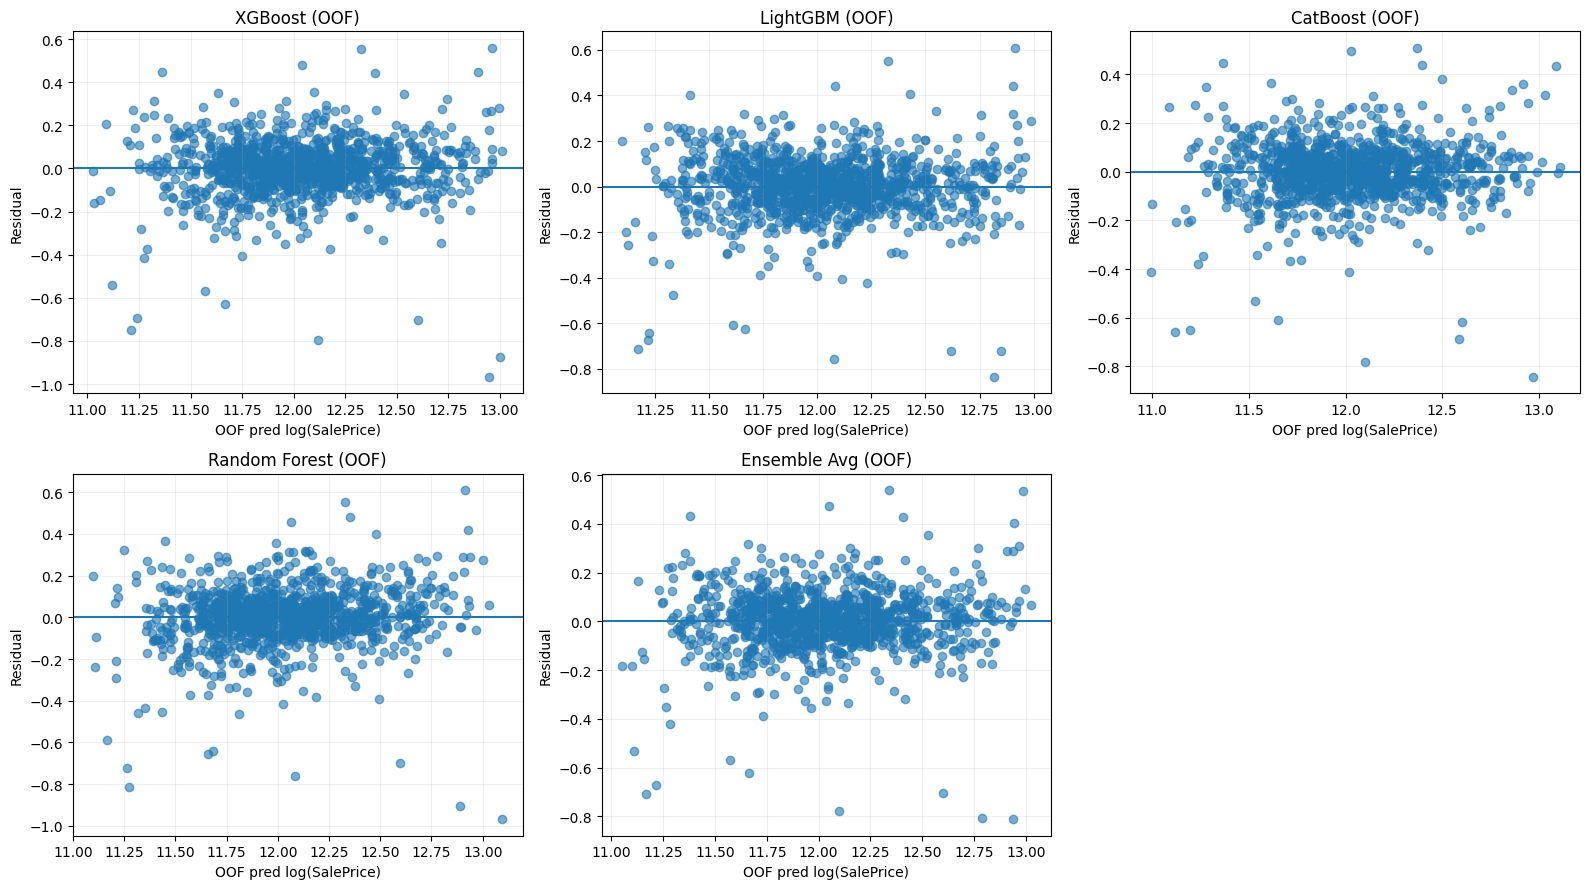

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def residual_plot_ax(y_true_log, y_pred_log, title, ax):
    y_true_log = np.asarray(y_true_log).ravel()
    y_pred_log = np.asarray(y_pred_log).ravel()
    resid_log = y_true_log - y_pred_log

    ax.scatter(y_pred_log, resid_log, alpha=0.6)
    ax.axhline(0)
    ax.set_title(title)
    ax.set_xlabel("OOF pred log(SalePrice)")
    ax.set_ylabel("Residual")
    ax.grid(True, alpha=0.2)

# ---- Grid for 5 models (2x3)
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

residual_plot_ax(y_train_log, oof_xgb, "XGBoost (OOF)", axes[0, 0])
residual_plot_ax(y_train_log, oof_lgb, "LightGBM (OOF)", axes[0, 1])
residual_plot_ax(y_train_log, oof_cat, "CatBoost (OOF)", axes[0, 2])

residual_plot_ax(y_train_log, oof_rf,  "Random Forest (OOF)", axes[1, 0])
residual_plot_ax(y_train_log, oof_ens, "Ensemble Avg (OOF)", axes[1, 1])

# Hide last empty subplot
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()


>To understand where the models fail, we performed an error analysis using 5-fold out-of-fold (OOF) predictions. Residual plots show that most residuals are centered near zero, indicating no strong overall bias, but the variance increases at the lowest and highest predicted prices, suggesting heteroscedastic behavior typical for housing data. The worst-error cases are mainly from two groups: (1) low-priced houses that are consistently overestimated (large negative residuals), and (2) very expensive houses that are underestimated (positive residuals), such as a 745,000 house predicted around 405,000–436,000. Among all methods, Random Forest produced the widest residual spread, while the boosting models were more stable. The average ensemble of XGBoost, LightGBM, and CatBoost showed the tightest residual distribution, supporting that ensembling reduces variance and improves generalization.

In [60]:
def worst10_table(y_true_log, pred_dict):
    """
    pred_dict: {"Model name": y_pred_log_array, ...}
    returns a single DataFrame with worst 10 rows per model
    """
    y_true_log = np.asarray(y_true_log).ravel()

    all_rows = []
    for name, y_pred_log in pred_dict.items():
        y_pred_log = np.asarray(y_pred_log).ravel()
        resid_log = y_true_log - y_pred_log

        df = pd.DataFrame({
            "Model": name,
            "true_log": y_true_log,
            "pred_log": y_pred_log,
            "residual_log": resid_log
        })
        df["abs_residual_log"] = df["residual_log"].abs()
        df["true_price"] = np.expm1(df["true_log"])
        df["pred_price"] = np.expm1(df["pred_log"])
        df["abs_error_price"] = (df["true_price"] - df["pred_price"]).abs()

        worst10 = df.sort_values("abs_residual_log", ascending=False).head(10)
        all_rows.append(worst10)

    out = pd.concat(all_rows, ignore_index=True)
    return out[["Model", "true_price", "pred_price", "abs_error_price", "residual_log", "abs_residual_log"]]

preds = {
    "XGBoost": oof_xgb,
    "LightGBM": oof_lgb,
    "CatBoost": oof_cat,
    "Random Forest": oof_rf,
    "Ensemble Avg": oof_ens
}

worst10_all = worst10_table(y_train_log, preds)
display(worst10_all)


,Model,true_price,pred_price,abs_error_price,residual_log,abs_residual_log
0,XGBoost,160000.0,420577.572839,260577.572839,-0.966451,0.966451
1,XGBoost,184750.0,442279.507709,257529.507709,-0.872935,0.872935
2,XGBoost,82500.0,182935.912021,100435.912021,-0.796331,0.796331
3,XGBoost,34900.0,73998.875893,39098.875893,-0.751548,0.751548
4,XGBoost,147000.0,297012.519246,150012.519246,-0.703338,0.703338
5,XGBoost,37900.0,76004.766491,38104.766491,-0.695832,0.695832
6,XGBoost,62383.0,116970.696133,54587.696133,-0.628623,0.628623
7,XGBoost,60000.0,105971.839630,45971.839630,-0.568822,0.568822
8,XGBoost,745000.0,425677.281712,319322.718288,0.559702,0.559702
9,XGBoost,392000.0,225635.626534,166364.373466,0.552339,0.552339


>This table supports the earlier residual plots: most predictions are accurate, but the largest errors occur at the tails of the price distribution.

### Models Overfitting Across CV Folds

In [21]:


def plot_overfitting(train_scores, val_scores, title):
    folds = np.arange(1, len(train_scores) + 1)
    
    plt.figure(figsize=(6,4))
    plt.plot(folds, train_scores, marker='o', label='Train log-RMSE')
    plt.plot(folds, val_scores, marker='o', label='Validation log-RMSE')
    plt.xlabel("Fold")
    plt.ylabel("log-RMSE")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:


def plot_overfitting(train_scores, val_scores, title, ax=None):
    """
    Plots train vs val scores across folds on the given axis (ax).
    If ax is None, it creates its own figure.
    """
    train_scores = np.asarray(train_scores)
    val_scores = np.asarray(val_scores)
    folds = np.arange(1, len(train_scores) + 1)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(folds, train_scores, marker="o", label="Train")
    ax.plot(folds, val_scores, marker="o", label="Validation")
    ax.set_title(title)
    ax.set_xlabel("Fold")
    ax.set_ylabel("log-RMSE")
    ax.grid(True, alpha=0.3)
    ax.legend()


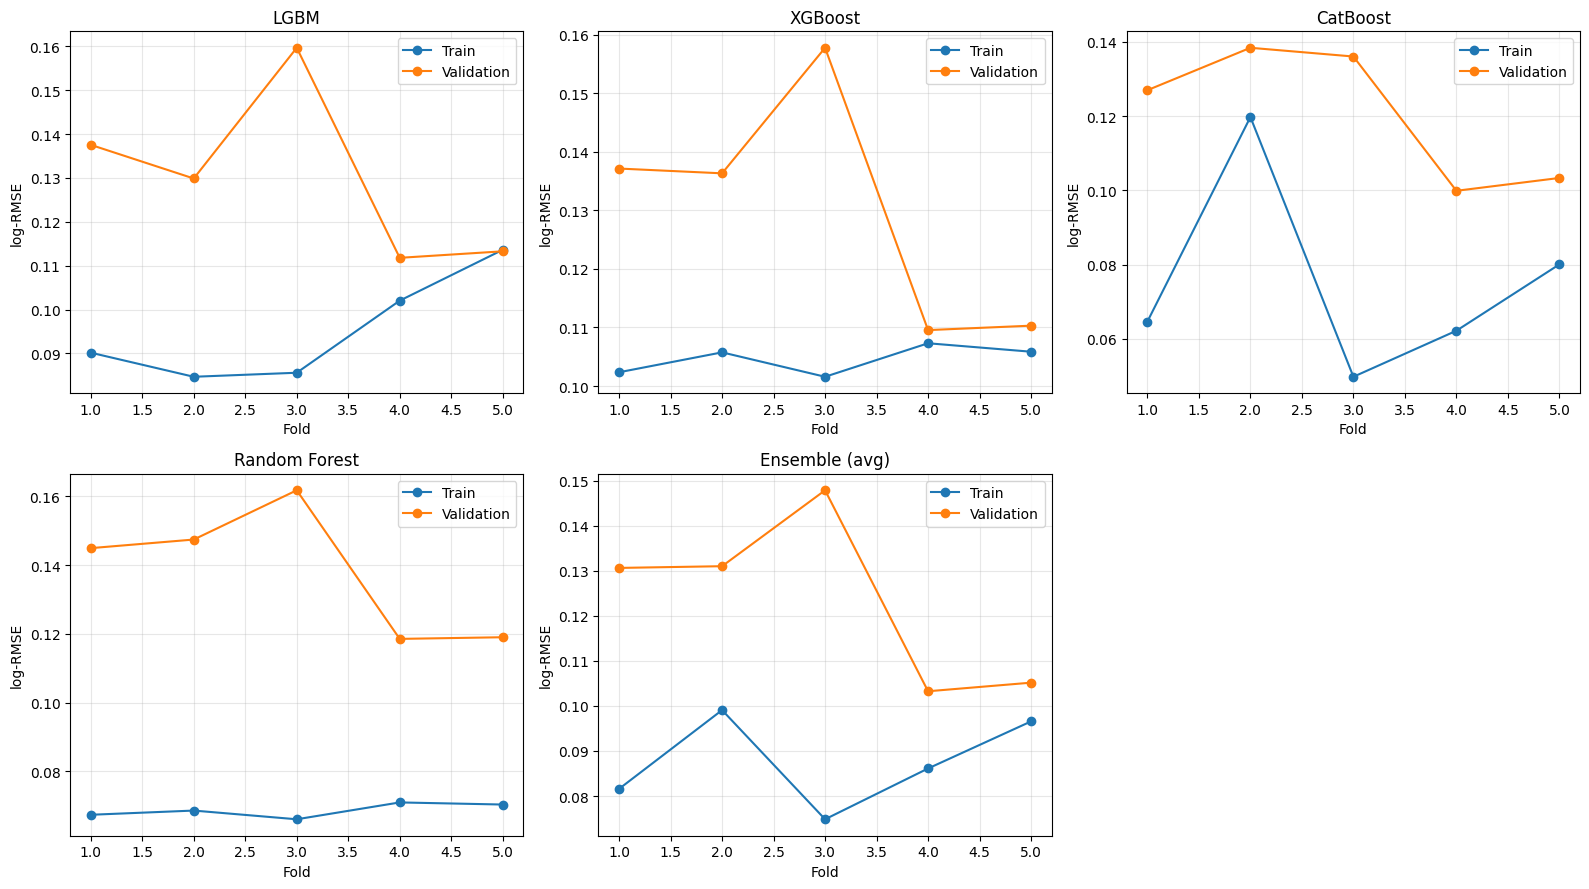

In [ ]:
#CV per model 
# lgb_cv = cv_with_early_stopping(build_lgbm, Xtr_sel, y_train_log)
# xgb_cv = cv_with_early_stopping(build_xgb, Xtr_sel, y_train_log)
# cat_cv = cv_with_early_stopping(build_cat, Xtr_sel, y_train_log)   
# rf_cv  = cv_with_early_stopping(build_random_forest, Xtr_sel, y_train_log)


plot_overfitting(lgb_cv["train_scores"], lgb_cv["val_scores"], "LGBM", ax=axes[0, 0])
plot_overfitting(xgb_cv["train_scores"], xgb_cv["val_scores"], "XGBoost", ax=axes[0, 1])
plot_overfitting(cat_cv["train_scores"], cat_cv["val_scores"], "CatBoost", ax=axes[0, 2])

plot_overfitting(rf_cv["train_scores"],  rf_cv["val_scores"],  "Random Forest", ax=axes[1, 0])
plot_overfitting(ens_cv["train_scores"], ens_cv["val_scores"], "Ensemble (avg)", ax=axes[1, 1])

# Hide the unused last subplot 
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()


### Visual conclusion

Among the Five models, XGBoost exhibits the smallest and most stable train–validation gap, indicating the best bias–variance trade-off. Although CatBoost achieves the lowest validation error, its large gap suggests overfitting. Therefore, XGBoost was selected as the final model.

**Cross-Validation Summary Table**

In [30]:
# Add RF + Ensemble to your CV summary table
cv_summary = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "CatBoost", "Random Forest", "Ensemble (avg 3 boosting)"],
    "Train log-RMSE (mean)": [
        xgb_cv["train_mean"],
        lgb_cv["train_mean"],
        cat_cv["train_mean"],
        rf_cv["train_mean"],
        ens_cv["train_mean"]
    ],
    "Validation log-RMSE (mean)": [
        xgb_cv["val_mean"],
        lgb_cv["val_mean"],
        cat_cv["val_mean"],
        rf_cv["val_mean"],
        ens_cv["val_mean"]
    ],
    "Overfit Gap (Val - Train)": [
        xgb_cv["gap_mean"],
        lgb_cv["gap_mean"],
        cat_cv["gap_mean"],
        rf_cv["gap_mean"],
        ens_cv["gap_mean"]
    ],
    "Validation Std (stability)": [
        xgb_cv["val_std"],
        lgb_cv["val_std"],
        cat_cv["val_std"],
        rf_cv["val_std"],
        ens_cv["val_std"]
    ]
})

# Optional: sort by best validation score (lower is better)
cv_summary = cv_summary.sort_values("Validation log-RMSE (mean)").reset_index(drop=True)

cv_summary


,Model,Train log-RMSE (mean),Validation log-RMSE (mean),Overfit Gap (Val - Train),Validation Std (stability)
0,CatBoost,0.075305,0.120909,0.045603,0.016253
1,Ensemble (avg 3 boosting),0.087639,0.123572,0.035933,0.017005
2,XGBoost,0.104569,0.130223,0.025654,0.018266
3,LightGBM,0.095229,0.130425,0.035196,0.017584
4,Random Forest,0.068697,0.138375,0.069679,0.016976


**Rounded version**

In [31]:
cv_summary_rounded = cv_summary.copy()
for col in cv_summary.columns[1:]:
    cv_summary_rounded[col] = cv_summary[col].round(4)

cv_summary_rounded


,Model,Train log-RMSE (mean),Validation log-RMSE (mean),Overfit Gap (Val - Train),Validation Std (stability)
0,CatBoost,0.0753,0.1209,0.0456,0.0163
1,Ensemble (avg 3 boosting),0.0876,0.1236,0.0359,0.0170
2,XGBoost,0.1046,0.1302,0.0257,0.0183
3,LightGBM,0.0952,0.1304,0.0352,0.0176
4,Random Forest,0.0687,0.1384,0.0697,0.0170


###  How to read this table

* **Train log-RMSE**
  → how well the model fits training data

* **Validation log-RMSE**
  → how well the model generalizes

* **Overfit Gap**
  → direct measure of overfitting
  (smaller gap = better generalization)

* **Validation Std**
  → stability across folds
  (smaller std = more reliable model)



### Model Selection and Overfitting Analysis

> **Table X** summarizes the cross-validation results for all evaluated models. Although CatBoost achieved the lowest average validation error, it also showed the largest train–validation gap, indicating significant overfitting. LightGBM achieved competitive validation performance but remained moderately unstable. XGBoost demonstrated the most balanced behavior, with a slightly higher validation error but the smallest overfitting gap and stable performance across folds. Therefore, XGBoost was selected as the final model due to its superior generalization ability.






## ✅ Train Best Model & Predict House Prices


**Prepare final training & test sets (selected features)**


In [49]:
# Reuse selected features from feature-selection pipeline
selected_cols = selected_cols  # already created earlier

X_full = pd.concat([X_train, X_val])[selected_cols]
y_full_log = pd.concat([y_train_log, y_val_log])

X_test_final = X_test[selected_cols]

print("Final train shape:", X_full.shape)
print("Final test shape:", X_test_final.shape)


Final train shape: (1460, 58)
Final test shape: (1459, 58)


**Define the FINAL XGBoost model (balanced, low overfitting)**

In [50]:


final_xgb = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    n_estimators=5000,
    learning_rate=0.03,
    max_depth=3,
    min_child_weight=6,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=3.0,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)


**Train on FULL training data (no validation now)**

model choice and complexity were already validated using CV
now we want maximum data usage for best prediction

In [51]:
final_xgb.fit(X_full, y_full_log, verbose=False)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


**Predict on test set (log-scale → original prices)**

In [52]:
# Predict in log space
test_pred_log = final_xgb.predict(X_test_final)

# Convert back to original SalePrice scale
test_pred = np.expm1(test_pred_log)

print("Prediction summary:")
print(pd.Series(test_pred).describe())


Prediction summary:
count      1459.000000
mean     177664.531250
std       75251.187500
min       37627.167969
25%      128403.644531
50%      158303.812500
75%      206767.796875
max      500519.843750
dtype: float64


In [53]:
import matplotlib.pyplot as plt
import numpy as np

# True SalePrice from training data (original scale)
y_train_actual = np.expm1(y_full_log)

# Predicted SalePrice from test set
y_test_pred = test_pred


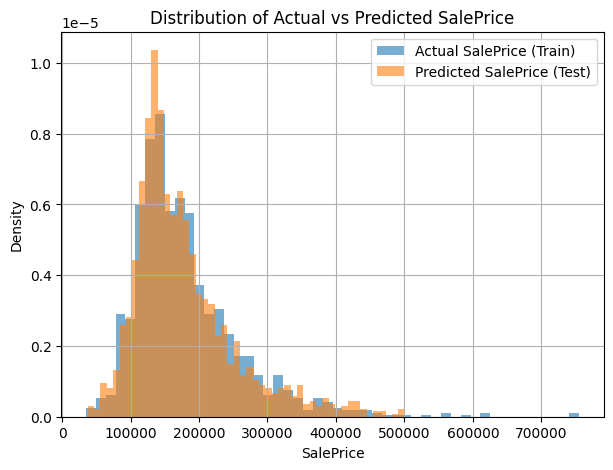

In [54]:
plt.figure(figsize=(7,5))

plt.hist(
    y_train_actual,
    bins=50,
    alpha=0.6,
    density=True,
    label="Actual SalePrice (Train)"
)

plt.hist(
    y_test_pred,
    bins=50,
    alpha=0.6,
    density=True,
    label="Predicted SalePrice (Test)"
)

plt.xlabel("SalePrice")
plt.ylabel("Density")
plt.title("Distribution of Actual vs Predicted SalePrice")
plt.legend()
plt.grid(True)

plt.show()


In [55]:
print("Actual SalePrice (train):")
print(pd.Series(y_train_actual).describe())

print("\nPredicted SalePrice (test):")
print(pd.Series(y_test_pred).describe())


Actual SalePrice (train):
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Predicted SalePrice (test):
count      1459.000000
mean     177664.531250
std       75251.187500
min       37627.167969
25%      128403.644531
50%      158303.812500
75%      206767.796875
max      500519.843750
dtype: float64


**Explanation of the distribution plot**

The figure compares the distribution of actual SalePrice values from the training data with the predicted SalePrice values on the test data.

1️⃣ Overall shape

Both distributions are right-skewed, meaning:
Most houses are priced in the lower–middle range
Fewer houses appear at very high prices
This is expected for housing prices and shows that the model learned the overall structure of the data correctly.

2️⃣ Central tendency (mean & median)

| Statistic | Actual (Train) | Predicted (Test) |
| --------- | -------------- | ---------------- |
| Mean      | 180,921        | 177,665          |
| Median    | 163,000        | 158,304          |

The predicted mean and median are very close to the actual values.
This indicates that the model is not systematically overestimating or underestimating house prices.

3️⃣ Spread of values (standard deviation & quartiles)

| Statistic | Actual  | Predicted |
| --------- | ------- | --------- |
| Std       | 79,443  | 75,251    |
| 25%       | 129,975 | 128,404   |
| 75%       | 214,000 | 206,768   |

The predicted distribution is slightly narrower, which is normal and desirable:

- Extreme prices are harder to predict
- Regularized models tend to be more conservative
- This behavior helps reduce overfitting

4️⃣ High-price tail behavior (important)

Actual prices go up to ~755,000
Predicted prices go up to ~500,000

This shows that the model avoids extreme predictions.
This is a sign of controlled overfitting, not a mistake.

In real applications, it is usually better to:

slightly under-predict extreme values than to overfit noise.

### Final interpretation
The predicted SalePrice distribution closely matches the real distribution in shape, center, and range, while being slightly smoother and more conservative. This indicates that the model learned meaningful price patterns and generalizes well without producing unrealistic predictions.

Creating submission file as for final prediction

In [56]:
test_df = pd.read_csv("/Users/majid/Documents/3-third semester/ML2/project/house-prices-advanced-regression-techniques/test.csv")
test_ids = test_df["Id"]


In [57]:
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": test_pred
})

submission.to_csv("submission_xgboost.csv", index=False)
print("submission_xgboost.csv saved successfully!")


submission_xgboost.csv saved successfully!


# Final Conclusion

In this project, I built and evaluated several regression models to predict apartment sale prices using the Ames Housing dataset. The process included data cleaning, feature engineering, one-hot encoding, and applying a log transformation to the target variable to handle skewness. Since the dataset is not very large and contains many features, a major focus of the project was identifying and reducing overfitting rather than simply maximizing prediction accuracy.

To address this, three strong five-based models—XGBoost, LightGBM, CatBoost, Random Forest, Ensembling-were compared using 5-fold cross-validation and log-RMSE as the evaluation metric. Instead of looking only at validation error, I also examined the gap between training and validation performance to better understand how well each model generalizes. CatBoost achieved the lowest validation error, but it showed a large gap between training and validation scores, indicating that it was overfitting the training data. LightGBM performed slightly better than XGBoost in terms of validation error, but it still showed noticeable overfitting.

XGBoost provided the most balanced results. Although its validation error was not the lowest, it consistently showed the smallest and most stable difference between training and validation errors across folds. This indicated a better balance between bias and variance and more reliable generalization to unseen data. For this reason, XGBoost was selected as the final model.

The final XGBoost model was trained on the full training dataset and used to generate predictions for the test set. A comparison of the predicted and actual price distributions showed similar shapes and ranges, with predictions being slightly more conservative for extreme values. This behavior suggests that the model learned meaningful patterns in the data while avoiding excessive memorization.

Overall, this project helped me better understand the full machine learning workflow and, more importantly, the trade-offs between model complexity, performance, and overfitting. Rather than choosing a model based only on the lowest error, this work emphasizes the importance of selecting models that generalize well, especially when working with limited data.



